# Predictive Modeling Challenge

**Mark Wilber**

The challenge here is to build a classifier for 56 FDA food safety violation categories, which are very unbalanced (sizes spanning more than 3 orders of magnitude). There are two components/features:

* a boolean, `FDAISCRITICAL`, indicating whether the violation is 'critical' or not
* a description of the violation, `VIOCOMMENT`, which can range from 0 to 844 'words'
  * (It is shown below, that the two instances with no comments can be safely dropped.)

This notebook generates TF-IDF features after extracting unigrams and bigrams, and trains models using logistic regression, random forest, linear SVC and complement Naive Bayes to compare f1 scores and training times.

<font color='darkgreen'>**As thise notebook is lengthy, readers will find it much easier to navigate with [Jupyter Nbextensions](https://github.com/ipython-contrib/jupyter_contrib_nbextensions) installed, and Table of Contents (2) selected:**</font>

## Preliminaries

**Next two lines are useful in the event of external code changes.**

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Python imports

**Next two lines are for pretty output for all prints in a Pandas cell, not just the last.**

In [27]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**`DataSci` contains generally helpful data science stuff, while `plotHelpers` includes plot functions specifically.**

In [64]:
import sys
sys.path.append('/home/mark/work/Mlib')
from utility import DataSci as util
from plotHelpers import plotHelpers as ph

In [29]:
from time import time, asctime, gmtime
print(asctime(gmtime()))

t0 = time()

# from platform import node
import os
from os.path import exists
# import shutil
# from glob import glob
from random import random
from collections import Counter, OrderedDict
import gc		# garbage collection module
import pprint
# import pickle
import timeit

print("Python version: ", sys.version_info[:])
print("Un-versioned imports:\n")
if 'sys' in sys.modules:
    print('sys', end="")
if 'utility' in sys.modules:
    print(', utility', end="")
if 'plotHelpers' in sys.modules:
    print(', plotHelpers', end="")
if 'platform' in sys.modules:
    print(', platform', end="")
if 'os' in sys.modules:
    print(', os', end="")
if 'os.path' in sys.modules:
    print(', os.path', end="")
if 'shutil' in sys.modules:
    print(', shutil', end="")
if 'glob' in sys.modules:
    print(', glob', end="")
if 'random' in sys.modules:
    print(', random', end="")
if 'collections' in sys.modules:
    print(', collections', end="")
if 'gc' in sys.modules:
    print(', gc', end="")
if 'pprint' in sys.modules:
    print(', pprint', end="")
if 'pickle' in sys.modules:
    print(', pickle', end="")
if 'timeit' in sys.modules:
    print(', timeit', end="")

duVersion = None
from dateutil import __version__ as duVersion
from dateutil.parser import parse
import numpy as np
import pandas as pd
import pyreadr

scVersion = None
from scipy import __version__ as scVersion
import scipy.sparse as sp

skVersion = None
from sklearn import __version__ as skVersion
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import ComplementNB

jlVersion = None
from joblib import __version__ as jlVersion
from joblib import dump, load

import seaborn as sns
import colorcet as cc

mpVersion = None
from matplotlib import __version__ as mpVersion
import matplotlib.pyplot as plt

print("\n")
if 'dateutil' in sys.modules:
    print(f"dateutil: {duVersion}", end="\t")
if 'numpy' in sys.modules:
    print(f"numpy: {np.__version__}", end="\t")
if 'pandas' in sys.modules:
    print(f"pandas: {pd.__version__}", end="\t")
if 'pyreader' in sys.modules:
    print(f"pyreader: {pyreader.__version__}", end="\t")
if 'scipy' in sys.modules:
    print(f"scipy: {scVersion}", end="\t")
# if 'tensorflow' in sys.modules:
#     print(f"tensorflow: {tfVersion}", end="\t")
# if 'keras' in sys.modules:
#     print(f"keras: {kerVersion}", end="\t")
if 'sklearn' in sys.modules:
    print(f"sklearn: {skVersion}", end="\t")
if 'joblib' in sys.modules:
    print(f"joblib: {jlVersion}", end="\t")
if 'seaborn' in sys.modules:
    print(f"seaborn: {sns.__version__}", end="\t")
if 'colorcet' in sys.modules:
    print(f"colorcet: {cc.__version__}", end="\t")
if 'matplotlib' in sys.modules:
    print(f"matplotlib: {mpVersion}", end="\t")
# if '' in sys.modules:
#     print(f": {.__version__}", end="\t")
Δt = time() - t0
print(f"\n\nΔt: {Δt: 4.1f}s.")

%matplotlib inline

Wed Apr  8 18:40:26 2020
Python version:  (3, 6, 9, 'final', 0)
Un-versioned imports:

sys, utility, plotHelpers, platform, os, os.path, shutil, glob, random, collections, gc, pprint, pickle, timeit

dateutil: 2.8.1	numpy: 1.18.1	pandas: 1.0.1	scipy: 1.4.1	sklearn: 0.22.1	joblib: 0.14.1	seaborn: 0.10.0	colorcet: 1.0.0	matplotlib: 3.1.3	

Δt:  0.0s.


## Handle the data

### Read data into a DataFrame

* Have a very quick look at DataFrame characteristics

In [30]:
cwd = pathlib.Path.cwd()
basePath = cwd.parent
dataPath = basePath / 'data'
dataSourcePath = dataPath / "SelectedInspectionReportData.rds"

t0 = time()
result = pyreadr.read_r(str(dataSourcePath))
df = result[None]
df.fda_q_fixed = df.fda_q_fixed.astype('int')
df.FDAISCRITICAL = df.FDAISCRITICAL.astype('int')
Δt = time() - t0
print(f"\n\nΔt: {Δt: 4.1f}s.")

df.shape



Δt:  9.7s.


(1307986, 12)

In [31]:
df.head(6).T
df.tail(6).T

,0,1,2,3,4,5
HZLVIOLATIONID,,,,,,
VIOCORRECTBYDATE,,,,,,
PICKLIST,6-301.11,4-601.11(A),4-204.112,3-302.12,6-404.11,4-501.11
VIOCOMMENT,Soap and/or paper towels are not provided for ...,Food contact surfaces and utensils are not cle...,An accurate product temperature-measuring devi...,Bulk containers are not properly labeled. V/C,Food products that are held by the food establ...,Non-food contact equipment is not maintained i...
FDAQUESTION,8,14,34,35,37,45
VIOISCOS,1,1,1,1,1,1
VIOLATIONID,,,,,,
FDAISCRITICAL,0,0,1,1,1,1
VIOISRPT,,,,,,
VIOCODE,,,,,,


,1307980,1307981,1307982,1307983,1307984,1307985
HZLVIOLATIONID,,,,,,
VIOCORRECTBYDATE,"January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00"
PICKLIST,6-501.11,6-501.12(1),3-305.11,4-903.11 (42),4-903.11 (42),4-501.11
VIOCOMMENT,"Floors, walls, and ceilings not in good repair","Floors, walls, and ceilings not clean",Food was not separated and protected from cont...,Equipment and utensils not properly installed ...,Equipment and utensils not properly stored or ...,Utensils and equipment unapproved or not in go...
FDAQUESTION,53,53,37,42,42,45
VIOISCOS,0,0,0,0,0,0
VIOLATIONID,100960663,100960664,100960679,100960681,100960682,100960680
FDAISCRITICAL,0,0,0,0,0,0
VIOISRPT,0,0,0,0,0,0
VIOCODE,53,53,37,45,42,45


#### Basic summary

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307986 entries, 0 to 1307985
Data columns (total 12 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   HZLVIOLATIONID    1307986 non-null  object 
 1   VIOCORRECTBYDATE  1307986 non-null  object 
 2   PICKLIST          1307986 non-null  object 
 3   VIOCOMMENT        1307986 non-null  object 
 4   FDAQUESTION       1307986 non-null  object 
 5   VIOISCOS          1307986 non-null  object 
 6   VIOLATIONID       1307986 non-null  object 
 7   FDAISCRITICAL     1307986 non-null  int64  
 8   VIOISRPT          1307986 non-null  object 
 9   VIOCODE           1307986 non-null  object 
 10  JURISDICTIONID    1307986 non-null  float64
 11  fda_q_fixed       1307986 non-null  int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 119.7+ MB


In [33]:
df.describe()

,FDAISCRITICAL,JURISDICTIONID,fda_q_fixed
count,1.307986e+06,1.307986e+06,1.307986e+06
mean,3.141234e-01,2.818328e+02,3.773050e+01
std,4.641660e-01,2.400974e+02,1.619210e+01
min,0.000000e+00,2.000000e+00,1.000000e+00
25%,0.000000e+00,1.360000e+02,2.200000e+01
50%,0.000000e+00,1.530000e+02,4.400000e+01
75%,1.000000e+00,3.880000e+02,5.000000e+01
max,1.000000e+00,9.730000e+02,5.600000e+01


#### Remove columns from DataFrame which we won't need

In [34]:
df = df[['fda_q_fixed', 'VIOCOMMENT', 'FDAISCRITICAL']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307986 entries, 0 to 1307985
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   fda_q_fixed    1307986 non-null  int64 
 1   VIOCOMMENT     1307986 non-null  object
 2   FDAISCRITICAL  1307986 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 29.9+ MB


### Exploratory analysis

#### Classes and relative balance

* The stuff using patches is for placing counts above each rectangle in the bar plot

In [35]:
FDAcodes = list(set(df['fda_q_fixed'].values))
print(FDAcodes)
classCts = pd.DataFrame(df['fda_q_fixed'].value_counts())
with pd.option_context("display.max_columns", 60):
    display(classCts.T)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]


,55,49,47,16,10,22,51,56,39,44,41,38,54,48,43,28,40,45,36,8,21,15,6,24,53,37,23,2,33,1,50,20,13,9,52,35,3,29,18,25,5,11,19,14,4,42,31,46,17,12,32,7,26,30,27,34
fda_q_fixed,171202,122314,121997,103357,69288,57210,56230,51223,46145,45333,42241,37133,30016,27602,26638,24426,24016,22845,21351,20585,18874,18156,15947,15218,13428,13294,12675,12630,11494,7844,7019,5747,5495,4213,3738,3513,2774,1910,1859,1770,1602,1550,1351,933,883,849,492,464,348,225,216,166,63,34,33,27


In [36]:
ph.plotValueCounts(df, 'fda_q_fixed', titleText='FDA code frequencies', saveAs='svg', ylim=[0.0, 187500.0])

AttributeError: module 'plotHelpers' has no attribute 'plotValueCounts'

***The class sizes span nearly 4 orders of magnitude!***

#### Word frequencies

In [ ]:
t0 = time()
df['commentsWords'] = df['VIOCOMMENT'].apply(lambda s: s.split())
t1 = time()
Δt = t1 - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")

In [ ]:
comments = list(df['commentsWords'])

##### Distribution of comment lengths

* Add length of each comment to DataFrame as `wordFreq` column

In [ ]:
wordLens = [len(wordList) for wordList in comments]
df['wordFreq'] = wordLens
wordFreqMode = df['wordFreq'].mode().values[0]

wordCtSorted = sorted(wordLens)
print("smallest word counts:\n", wordCtSorted[:100])
print("largest word counts:\n", wordCtSorted[-101:-1])

**Detailed histogram**

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 3.5))

ph.detailedHistogram(wordLens, ylabel='frequency', volubility=2,
                     titleText=f"Word counts (max: {wordCtSorted[-1]}, mode: {wordFreqMode})",
                     figName="WordCountsHist", ax=ax, ylim = [0.5, 100000.0], ylog=True, saveAs='svg')

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(18, 3.5))
# ax.hist(wordLens, bins=np.linspace(0, 845, 846))
# ax.set_yscale('log')
# ax.set_ylim([0.5, 100000.0])
# ax.set_ylabel('freqency')
# plt.title(f"Word counts (max: {wordCtSorted[-1]}, mode: {wordFreqMode})")
# plt.tight_layout(rect=[0, 0.03, 1, 0.975])
# plt.savefig("WordCountsHist.svg")

**Make space**

In [ ]:
del wordLens
del wordCtSorted
del df['commentsWords']

##### What FDA codes correspond to those comments having `wordFreq== 0`?

In [ ]:
df[df['wordFreq']==0]
print("\n", df.shape)

**Can safely remove a couple of records from the 2nd-most populated category**

* Originally there were 1307986 records in `df`, out of which 122314 were in Class 49

In [ ]:
df = df[df['wordFreq']!=0]
df.shape

##### `wordFreq` percentiles

* These show that would get 99% coverage of the comments without truncation if were to use, say, 140-element LSTMs

In [ ]:
df.describe(percentiles=[0.01, 0.05, 0.15, 0.25, 0.5, 0.75, 0.85, 0.95, 0.99])

#### Most-common words

In [ ]:
allWords = [word for wordList in comments for word in wordList]		# Flatten list of lists of words
print(len(comments), len(allWords))

print(comments[:5], "\n", allWords[:25])

In [ ]:
t0 = time()
wordCtr = Counter(allWords)
t1 = time()
Δt = t1 - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")

##### Most common words, after removing stop words

*Result looks very plausible*

In [ ]:
stopWords = text.ENGLISH_STOP_WORDS.union(['-'])

wcStops = [k for k in wordCtr if k.lower() in stopWords]
for k in wcStops:
    del wordCtr[k]
wordCtr.most_common(40)

#### Clean up

In [ ]:
del allWords
del wordCtr

#### `fda_q_fixed` vs. `FDAISCRITICAL`

What is the relationship between the critical violation boolean and the FDA code?

In [37]:
dfCrit = df.groupby(['fda_q_fixed', 'FDAISCRITICAL']).count()
del dfCrit['VIOCOMMENT']
del dfCrit['wordFreq']
dfCrit.head(20)

dfCrit.reset_index(inplace=True)
dfCrit.head(20)

KeyError: 'wordFreq'

In [ ]:
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.labeltop'] = True

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
dfCrit.plot.scatter('fda_q_fixed', 'FDAISCRITICAL', s=4, c='black', ax=ax)
for xv in np.linspace(0.5, 56.5, 57):
    _ = plt.axvline(x=xv, c="#FFB0FF", linewidth=1)
plt.suptitle('Critical violations vs FDA code')
ax.set_xlim([0.5, 56.5])
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig('CriticalViolationVsFDAcode.svg')

**The critical violations plot shows that `FDAISCRITICAL` should be predictive (and certainly should be included in the model):**

* **<font color="darkgreen">classes 30, 32, 34 &amp; 46 *never* have critical violations</font>**
* **<font color="darkgreen">classes 7, 26, 27 &amp; 29 *only* have critical violations</font>**

## Pre-process data

* Here we use TF-IDF features to represent the comment text.

### Split DataFrame by classes

* create a `numpy.random.RandomState` instance to keep track of the random number initializer, in order to ensure consistent results throughout

`splitDataFrameByClasses()` will create two new DataFrames, dfTr, dfTe, according to the desired splits.

<font color='darkgreen'><b>Note that if you just want to do stratified sampling on a numpy array of</b> `X` <b>values,</b> `splitDataFramByClasses()` <b>is not needed.</b> `train_test_split()` <b>accepts the keyword</b> `stratify=myTargetVariable`.</b></font>

* Splitting is done on a per-class basis, so that random selection will not, by chance, yield huge imbalances in train-test splits of tiny classes

In [38]:
randomState=0
myRandomState = np.random.RandomState(randomState)

In [39]:
classColumn = 'fda_q_fixed'
dfTr, dfTe = util.splitDataFrameByClasses(df, classColumn,
                                          testFrac=0.50,
                                          myRandomState=myRandomState)
dfTr.shape, dfTe.shape
dfTr.head()
dfTe.head()

Consider whether sklearn's built-in method would work instead:

    from sklearn.model_selection import     train_test_split
                  .
                  .
                  .
    Xtrain, Xtest, yTrain, yTest = \
        train_test_split(X, y, stratify=y)
df.shape: (1307986, 3)
dfTrain.shape: (653980, 3)	dfTest.shape: (654006, 3)
Δt:  2.21s.


((653980, 3), (654006, 3))

,fda_q_fixed,VIOCOMMENT,FDAISCRITICAL
0,43,Ice scoop,0
1,16,Intermediate - Accumulation of black/green mol...,1
2,41,Basic - Wiping cloth quaternary ammonium compo...,0
3,9,3717-1-03.2(A)(2) - Critical - Preventing cont...,1
4,22,High Priority - Potentially hazardous (time/te...,1


,fda_q_fixed,VIOCOMMENT,FDAISCRITICAL
0,50,Hot water in handsinks 105 F,0
1,22,High Priority - Potentially hazardous (time/te...,1
2,51,Plumbing not properly installed or maintained;...,0
3,22,3-501.16 (A)(2) and (B) Potentially Hazardous ...,1
4,49,Accumulation of food debris in condiment/bins ...,0


**As intended, `splitBalancedDataFrameClasses()` created a new train DataFrame with 10000 $\times$ 56 = 560000 rows, and a test DataFrame ~ 1307984/2 = 653992 rows.**

*The test DataFrame is not exactly an even split of the original, since the splitting is done by class and unioned.*

### TF-IDF

Let's compute TF-IDFs for each comment using scikit-learn's TF-IDF vectorizer.

* We'll use a logarithmic form: `sublinear_df=True`
* Ensure Euclidian norms for each vecture: `norm='l2'`
* Include bigrams, as well as unigrams: `ngram_range=(1,2)`
* English stop words: `stop_words='english'`
* toss very infrequent terms (appearing in fewer than 5 comments): `min_df=5`

#### Fit TF-IDF  features; transform train set (~40 seconds)

In [40]:
dfTe[['FDAISCRITICAL']].head(16).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
FDAISCRITICAL,0,1,0,1,0,1,1,0,0,1,0,0,0,1,0,1


In [41]:
t0 = time()
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',
                        encoding='latin-1', ngram_range=(1, 2),
                        stop_words='english')
Xtr = tfidf.fit_transform(dfTr.VIOCOMMENT)
Xtr.shape
yTr = dfTr.fda_q_fixed
t1 = time()
Δt = t1 - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")

(653980, 196110)

Δt: 31.6s.


**Xtr has 653979 ~ 653992 = 1307984 / 2 rows and ~196k columns. The latter represent the ~196k features in the training set unigram and bigram 'vocabulary'**

In [42]:
type(Xtr)
for i, row in enumerate(Xtr):
    if i > 1:
        break
    print(i, "\n", row)
    i += 1

scipy.sparse.csr.csr_matrix

0 
   (0, 91861)	0.6830700901485942
  (0, 154836)	0.6106475951745296
  (0, 91479)	0.4006554210939308
1 
   (0, 189607)	0.1472902300751636
  (0, 145896)	0.11553605399955431
  (0, 168388)	0.22658484443350124
  (0, 189958)	0.2224095425262336
  (0, 22992)	0.3092103772718877
  (0, 91525)	0.16549608407501343
  (0, 99238)	0.23304336965481842
  (0, 107555)	0.2181629812263538
  (0, 107518)	0.20228662426385344
  (0, 91747)	0.2068244251371583
  (0, 96293)	0.1730492623103784
  (0, 172004)	0.1900579211844591
  (0, 103731)	0.1511594807129587
  (0, 114910)	0.144186023791011
  (0, 83659)	0.1725687571147889
  (0, 23253)	0.1724926708633559
  (0, 12688)	0.16663884898384462
  (0, 96459)	0.15997889671618434
  (0, 191427)	0.10043940002997255
  (0, 189252)	0.09240198694223298
  (0, 145659)	0.104778480936598
  (0, 167936)	0.11915004149431722
  (0, 189948)	0.20597089132297394
  (0, 22775)	0.15062154857403248
  (0, 98962)	0.10818916814442701
  (0, 107063)	0.1660203186121834
  (0, 96180)	0.13147393597418497
  (0

#### Transform test set (~35 seconds)

In [43]:
t0 = time()
Xte = tfidf.transform(dfTe.VIOCOMMENT)
Xte.shape
yTe = dfTe.fda_q_fixed
t1 = time()
Δt = t1 - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")

(654006, 196110)

Δt: 28.2s.


**same number of columns for Xte, as for Xtr.**

#### Sanity check: show features most correlated with classes

* Figure out which of 196k features are most correlated with each of the FDA codes (~1 minute, 10 seconds)

In [44]:
t0 = time()
N = 5

FDAcodes = sorted(list(set(df.fda_q_fixed)))

for FDAcode in FDAcodes:
    Xχ2 = chi2(Xtr, yTr==FDAcode)
    indices = np.argsort(Xχ2[0])
    featureNames = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in featureNames if len(v.split(' ')) == 1]
    bigrams = [v for v in featureNames if len(v.split(' ')) == 2]
    print(f"\nFCA code {FDAcode:02d}:")
    print("Most correlated unigrams::\t{{{}".format('}  {'.join(unigrams[-N:])), end='}')
    print("\nMost correlated bigrams::\t{{{}".format('}  {'.join(bigrams[-N:])), end='}')
t1 = time()
Δt = t1 - t0
print(f"\n\nΔt: {int(Δt//60)}m, {Δt % 60.0:4.1f}s.")


FCA code 01:
Most correlated unigrams::	{demonstrate}  {duties}  {violations}  {knowledge}  {demonstration}
Most correlated bigrams::	{11 demonstration}  {demonstration priority}  {knowledge food}  {priority violations}  {demonstration knowledge}
FCA code 02:
Most correlated unigrams::	{http}  {accredited}  {certificate}  {certification}  {certified}
Most correlated bigrams::	{protection manager}  {food safety}  {manager certification}  {food manager}  {certified food}
FCA code 03:
Most correlated unigrams::	{illnesses}  {conditional}  {policy}  {reporting}  {symptoms}
Most correlated bigrams::	{employees informed}  {responsibility report}  {conditional employees}  {health policy}  {employee health}
FCA code 04:
Most correlated unigrams::	{infections}  {wound}  {ill}  {reinstatements}  {exclusions}
Most correlated bigrams::	{ill employees}  {records exclusions}  {employees maintained}  {maintained operator}  {exclusions restrictions}
FCA code 05:
Most correlated unigrams::	{fecal}  {r

#### Add `FDAISCRITICAL` column vales to `Xtr` and `Xte`

In [45]:
Xtrp = sp.hstack([Xtr, sp.csr_matrix(dfTr[['FDAISCRITICAL']])], 'csr')
np.shape(Xtrp)

(653980, 196111)

In [46]:
Xtep = sp.hstack([Xte, sp.csr_matrix(dfTe[['FDAISCRITICAL']])], 'csr')
np.shape(Xtep)

(654006, 196111)

In [47]:
del Xtr
del Xte

### Do some garbage collection before building models

In [48]:
for i in range(2):
    print('\nCollecting {} ...'.format(i))
    n = gc.collect()
    print('Unreachable objects:', n)
    print('Remaining Garbage:', end=' ')
    pprint.pprint(gc.garbage)


Unreachable objects: 73
Remaining Garbage: []

Unreachable objects: 0
Remaining Garbage: []


## Models

### Logistic Regression

#### TF-IDF with `FDAISCRITICAL`

* Run defaults for now, except `class_weight='balanced'`
* `n_jobs=7` means use 8 processors (as it is set to $n_{\mathrm{threads}} - 1$)
* For np.shape(Xtrp) = (560000, 196227), fit takes ~30 min.

In [51]:
np.shape(Xtrp), np.shape(yTr), np.shape(Xtep), np.shape(yTe)

((653980, 196111), (653980,), (654006, 196111), (654006,))

In [52]:
print(asctime(gmtime()))
LRname = 'LogisticRegressor0.joblib'

if os.path.isfile(LRname):
    LR = load(LRname)
    t1 = time()
else:
    CV = 5
    LR = LogisticRegression(random_state=myRandomState, n_jobs=7,
                            solver='newton-cg', class_weight='balanced')
    t0 = time()
    LR.fit(Xtrp, yTr)
    t1 = time()
    Δt01 = t1 - t0
    print("Δt01: {0} m, {1:4.1f} s.".format(int(Δt01//60), Δt01 % 60.0))

yPred = LR.predict(Xtep)
t2 = time()
Δt12 = t2 - t1
print("Δt12: {0} m, {1:4.1f} s.".format(int(Δt12//60), Δt12 % 60.0))

Wed Apr  8 18:47:53 2020


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=7, penalty='l2',
                   random_state=RandomState(MT19937) at 0x7F8D2CF1C888,
                   solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

Δt01: 151 m, 45.7 s.
Δt12: 0 m,  2.5 s.


In [53]:
print(yTe[:20].values)
print(yPred[:20])

[50 22 51 22 49 16 28 44 51 16 45 55 55 16 48 21 38 33 38 55]
[31 22 51 25 49 15 28 39 51 16 39 55 55 16 48 21 38 33 38 55]


**Save model to disk**

In [54]:
if not os.path.isfile(LRname):
    dump(LR, LRname)

['LogisticRegressor0.joblib']

#### Overall accuracy, precision, recall

In [55]:
confusionMat = confusion_matrix(yTe, yPred)
print(confusionMat)

[[ 3062   313   252 ...     0     0     0]
 [  425  5743    80 ...     0     0     0]
 [   64    26  1208 ...     0     0     0]
 ...
 [    0     0     0 ... 13711   257    57]
 [    8     4     0 ...   546 66113  2938]
 [    2     1     0 ...    49  1104 21018]]


In [56]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

accuracy: 0.846, <precision>: 0.720, <recall>: 0.836


##### Recall, precision by class

Note:

* `macro avg`: $\frac{1}{K}\sum_k m_k$, where $K$ is count of classes and $m_k$ is a given metric for class $k$
* `weighted avg`: $\frac{1}{N}\sum_k n_k \cdot m_k$, where $N$ is count of data instance, $n_k$ is the count of points in class $k$ and $m_k$ is a given metric for class $k$.

In [57]:
print(metrics.classification_report(yTe.values, yPred, target_names=[str(c)for c in FDAcodes]))

              precision    recall  f1-score   support

           1       0.79      0.78      0.78      3922
           2       0.91      0.91      0.91      6315
           3       0.73      0.87      0.80      1387
           4       0.52      0.72      0.60       442
           5       0.88      0.93      0.90       801
           6       0.93      0.92      0.92      7974
           7       0.44      0.84      0.58        83
           8       0.89      0.88      0.88     10293
           9       0.79      0.90      0.85      2107
          10       0.97      0.96      0.96     34644
          11       0.49      0.69      0.57       775
          12       0.36      0.51      0.43       113
          13       0.71      0.81      0.76      2748
          14       0.82      0.90      0.86       467
          15       0.89      0.87      0.88      9078
          16       0.96      0.94      0.95     51679
          17       0.59      0.66      0.62       174
          18       0.73    

In [58]:
classCts = dfTe['fda_q_fixed'].value_counts()

recall = np.diag(confusionMat)/np.sum(confusionMat, axis = 1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis = 0)
f1 = 2.0*precision*recall/(precision + recall)
print("class\tprecision\trecall\tf1\tsize")

for FDAcode, classCt in classCts.iteritems():
    print(f"{FDAcode}\t{precision[FDAcode - 1]:0.3f}\t\t{recall[FDAcode - 1]:0.3f}\t{f1[FDAcode - 1]:0.3f}\t\t{classCt:d}")

class	precision	recall	f1	size
55	0.879		0.772	0.822		85601
49	0.783		0.792	0.788		61157
47	0.827		0.727	0.774		60999
16	0.963		0.941	0.952		51679
10	0.970		0.959	0.965		34644
22	0.926		0.812	0.865		28605
51	0.835		0.841	0.838		28115
56	0.783		0.821	0.801		25612
39	0.816		0.819	0.818		23073
44	0.855		0.762	0.806		22667
41	0.907		0.935	0.921		21121
38	0.886		0.942	0.913		18567
54	0.917		0.914	0.915		15008
48	0.744		0.842	0.790		13801
43	0.785		0.877	0.828		13319
28	0.900		0.954	0.926		12213
40	0.951		0.948	0.950		12008
45	0.716		0.884	0.791		11423
36	0.875		0.933	0.903		10676
8	0.885		0.884	0.885		10293
21	0.756		0.834	0.793		9437
15	0.886		0.870	0.878		9078
6	0.926		0.923	0.924		7974
24	0.850		0.860	0.855		7609
53	0.629		0.891	0.738		6714
37	0.874		0.920	0.897		6647
23	0.890		0.894	0.892		6338
2	0.913		0.909	0.911		6315
33	0.686		0.931	0.790		5747
1	0.789		0.781	0.785		3922
50	0.721		0.918	0.808		3510
20	0.739		0.926	0.822		2874
13	0.712		0.814	0.760		2748
9	0.794		0.903	0.845		2107
52

##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

In [59]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

fileNameAugmentString:
 LogisticRegression
Δt:  5.16s.


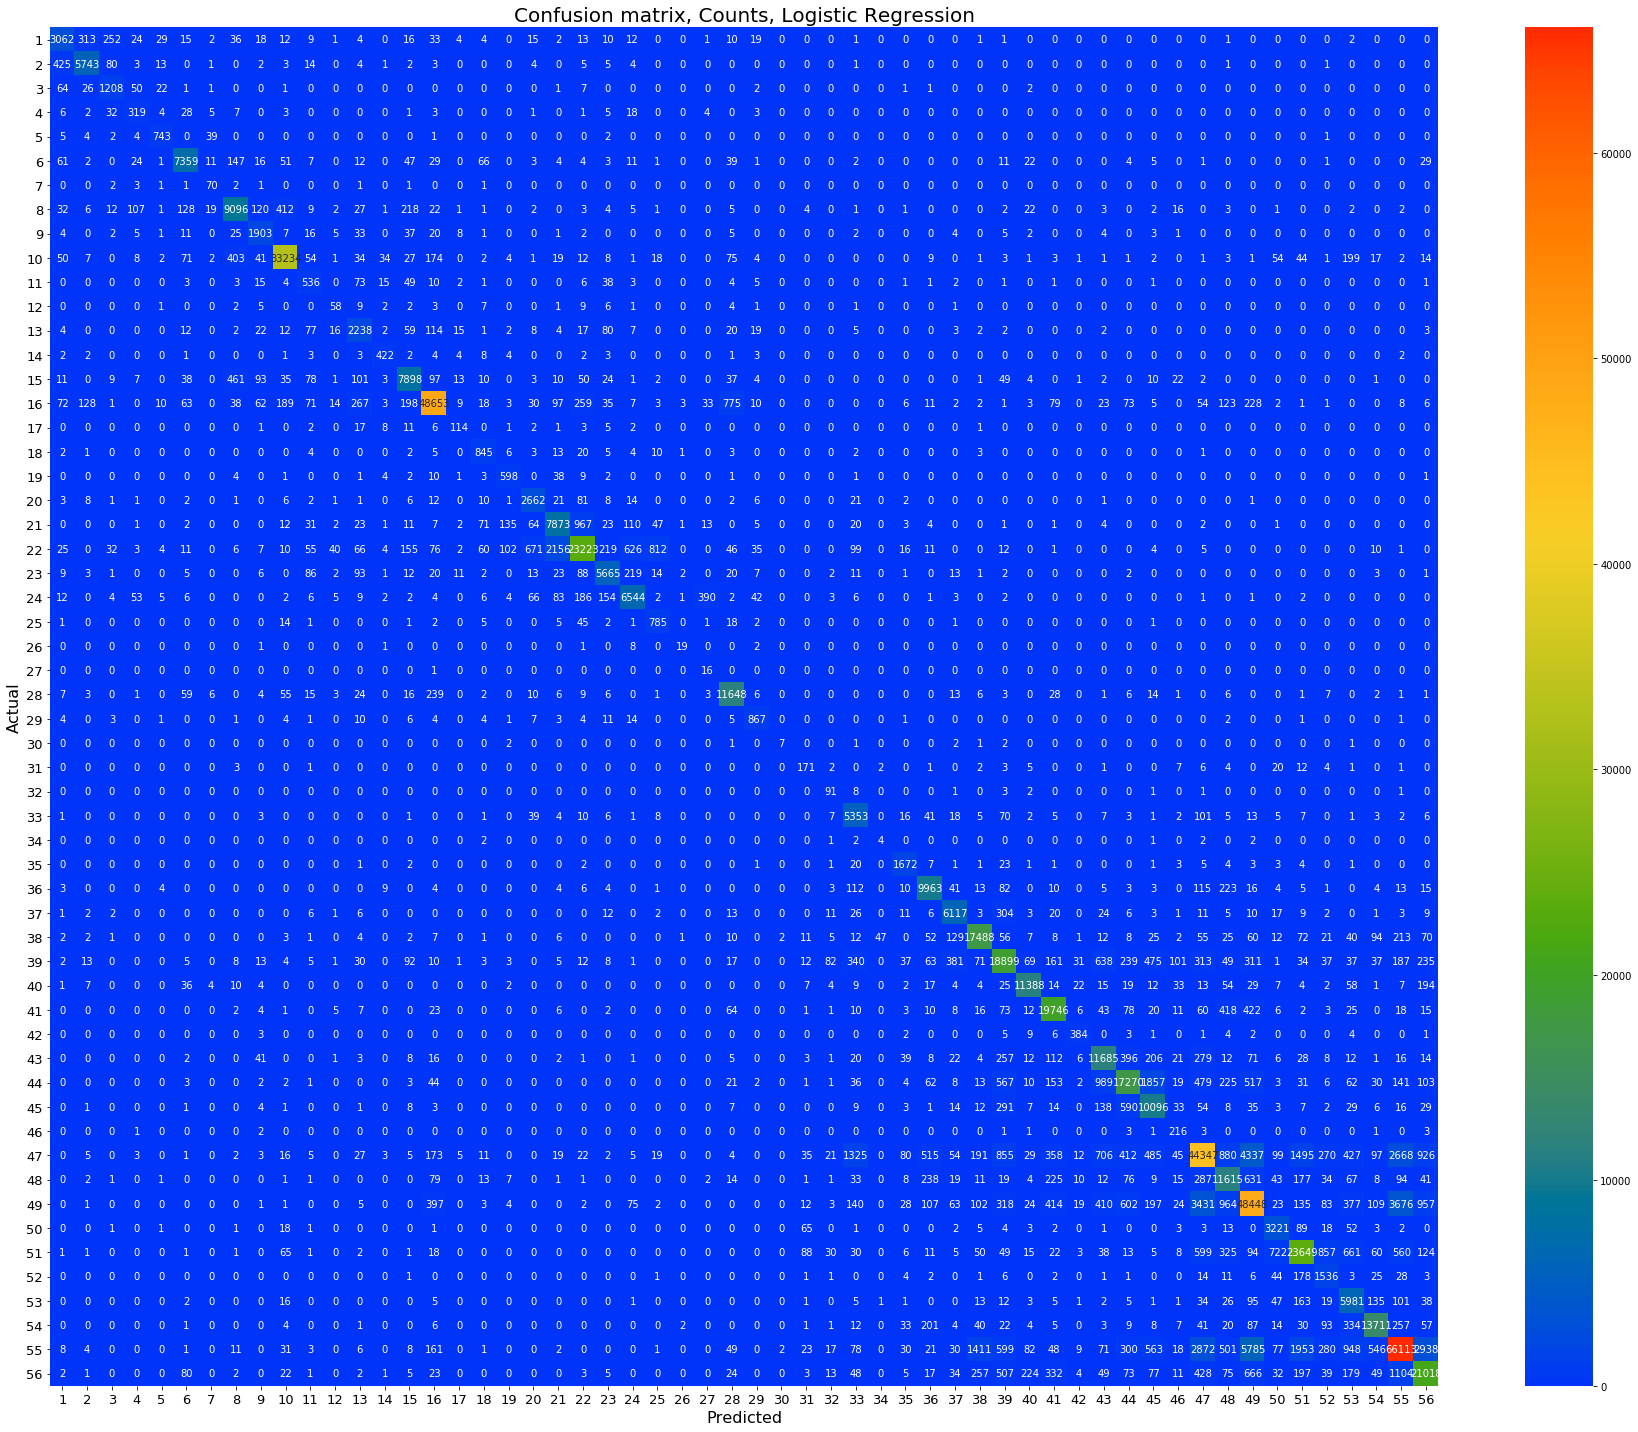

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes,
                       ylabels=FDAcodes, titleText = 'Logistic Regression',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix (normalized by row)

* diagonal elements now represent the *recall* for each class

fileNameAugmentString:
 LogisticRegression
Δt:  5.54s.


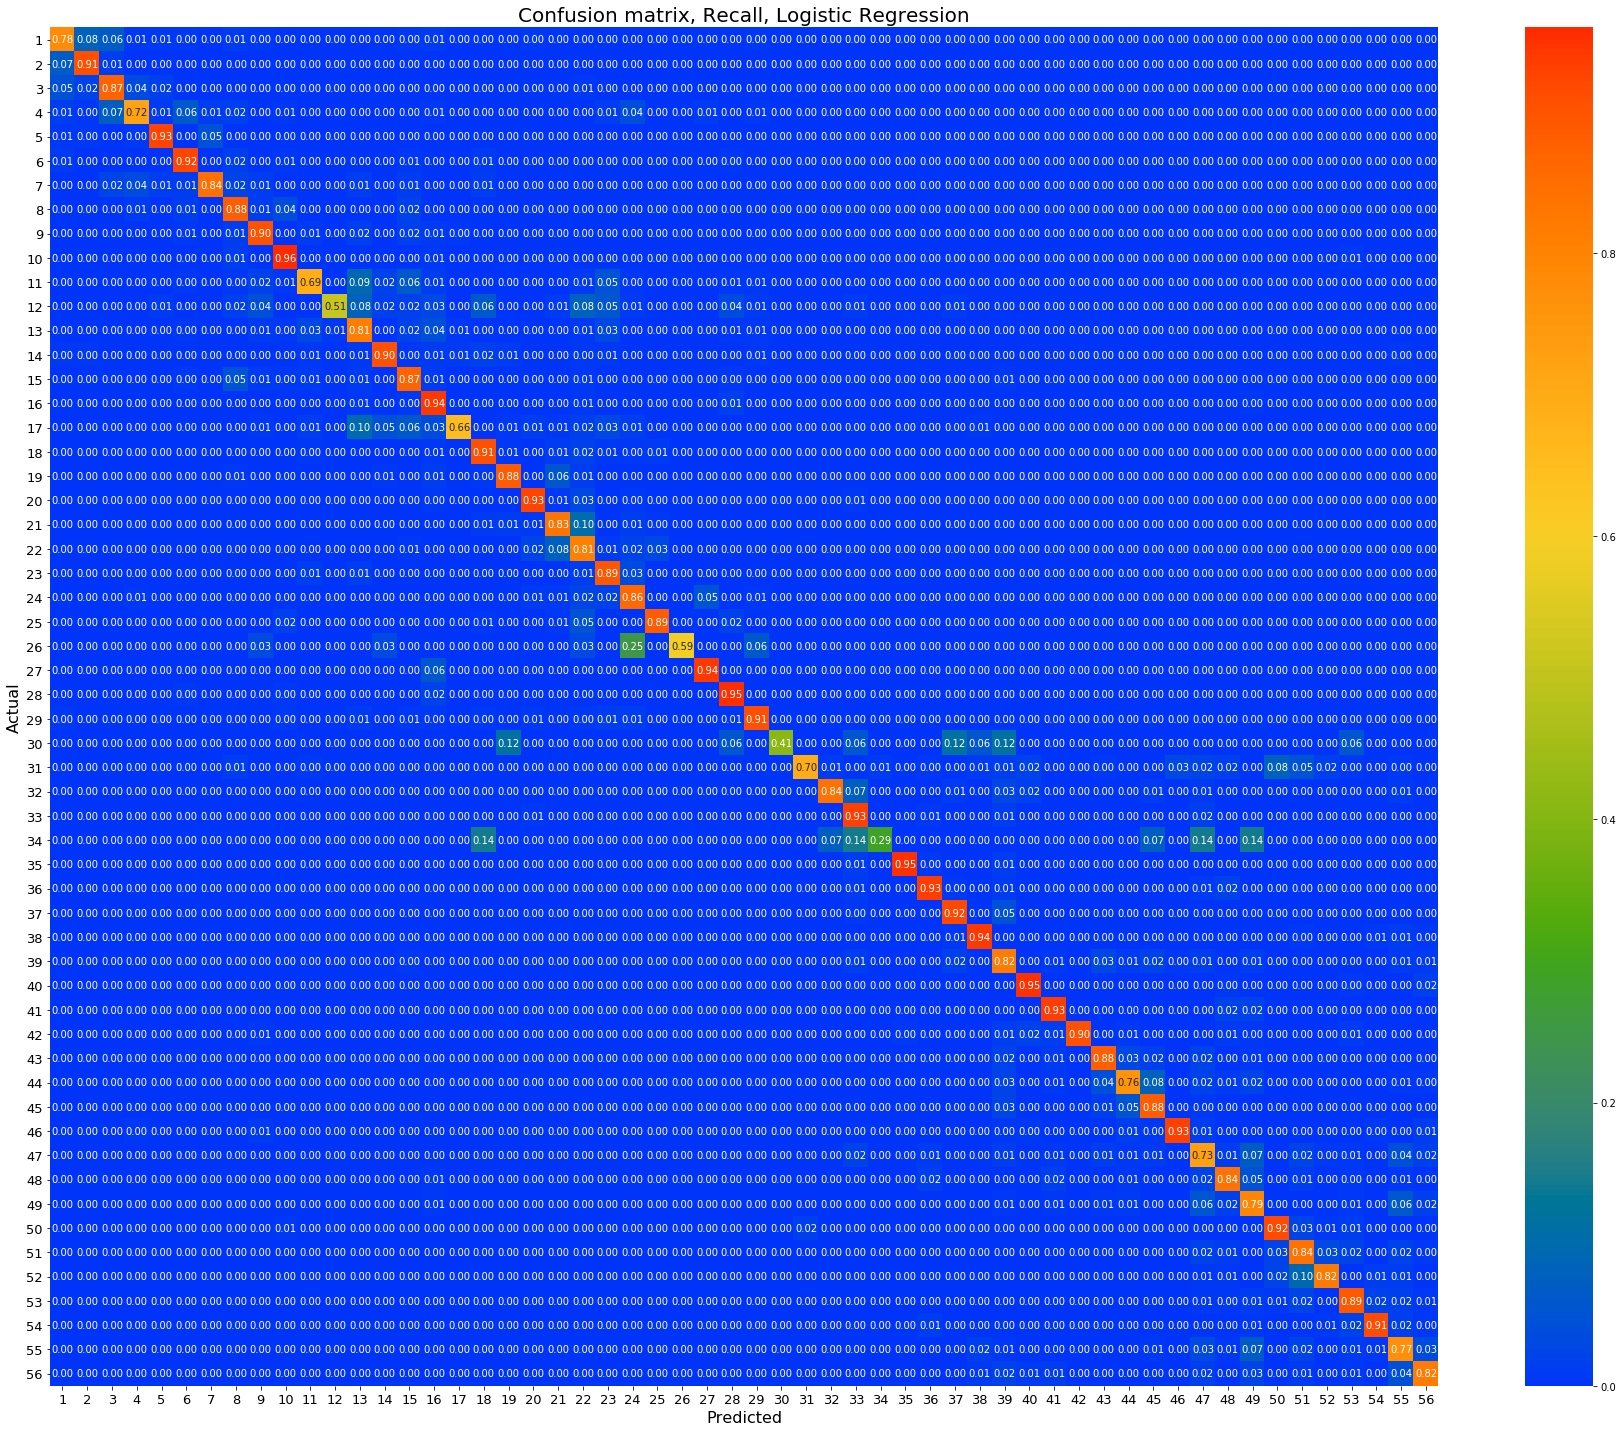

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='recall',
                       ylabels=FDAcodes, titleText = 'Logistic Regression',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix (normalized by column)

* diagonal elements now represent the *precision* for each class

fileNameAugmentString:
 LogisticRegression
Δt:  5.73s.


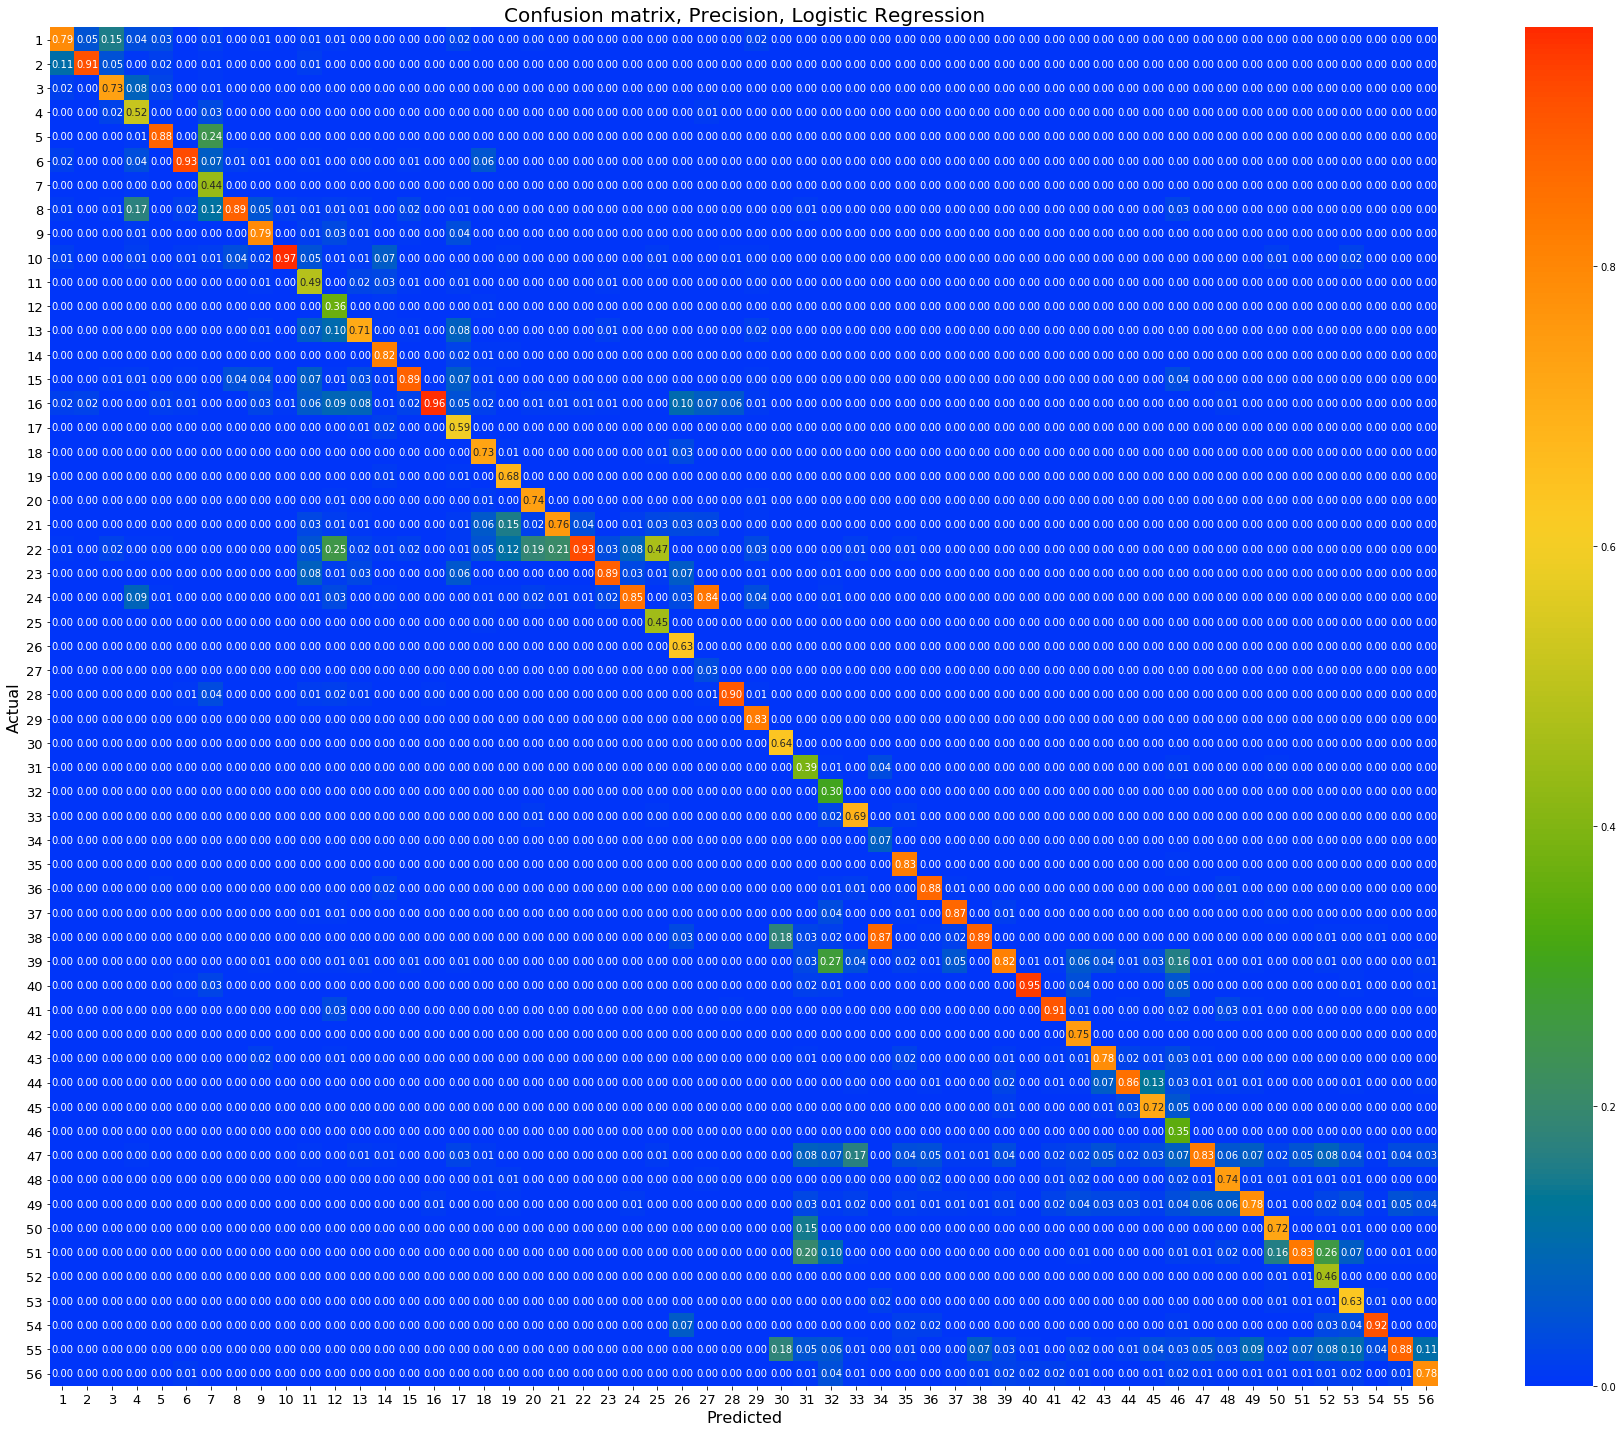

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='precision',
                       ylabels=FDAcodes, titleText = 'Logistic Regression',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

In [69]:
del LR

#### Do some garbage collection before building RF models

In [70]:
for i in range(2):
    print('\nCollecting {} ...'.format(i))
    n = gc.collect()
    print('Unreachable objects:', n)
    print('Remaining Garbage:', end=' ')
    pprint.pprint(gc.garbage)


Unreachable objects: 0
Remaining Garbage: []

Unreachable objects: 0
Remaining Garbage: []


### Random Forest

#### TF-IDF with `FDAISCRITICAL`, `max_depth=250`

* Run defaults for now, except `n_estimators=160` (default is 10)
* For np.shape(Xtr) = (560000, 178558), fit takes ~150 min.

<font color='darkred'>***The very long training time in this instance is due to memory swapping.
(Fortunately, on my 12 GB machine, the swap space is on a flash drive.)
Reducing the `max_depth` from 250 should help to reduce the memory requirements.***</font>

In [71]:
np.shape(Xtrp), np.shape(yTr), np.shape(Xtep), np.shape(yTe)

((653980, 196111), (653980,), (654006, 196111), (654006,))

In [72]:
print(asctime(gmtime()))
RFname = 'RandomForest0.joblib'

if os.path.isfile(RFname):
    RF = load(RFname)
    t1 = time()
else:
    RF = RandomForestClassifier(random_state=myRandomState, n_jobs=7, n_estimators=160,
                                max_depth=250, class_weight='balanced')
    t0 = time()
    RF.fit(Xtrp, yTr)
    t1 = time()
    Δt01 = t1 - t0
    print("Δt01: {0} m, {1:4.1f} s.".format(int(Δt01//60), Δt01 % 60.0))

yPred = RF.predict(Xtep)
t2 = time()
Δt12 = t2 - t1
print("Δt12: {0} m, {1:4.1f} s.".format(int(Δt12//60), Δt12 % 60.0))

Wed Apr  8 22:51:02 2020


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=250, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=7,
                       oob_score=False,
                       random_state=RandomState(MT19937) at 0x7F8D2CF1C888,
                       verbose=0, warm_start=False)

Δt01: 89 m, 50.1 s.
Δt12: 0 m, 22.8 s.


In [73]:
print(yTe[:20].values)
print(yPred[:20])

[50 22 51 22 49 16 28 44 51 16 45 55 55 16 48 21 38 33 38 55]
[50 22 51 22 49 16 28 44 51 16 39 55 55 16 48 21 38 33 38 55]


**Save model to disk**

<font color="darkred">Nope. Not agonna do this; model is yuge &mdash; 15 GB!</font>

In [111]:
if not os.path.isfile(RFname):
    dump(RF, RFname)

NameError: name 'RF' is not defined

#### Overall accuracy, precision, recall

In [75]:
confusionMat = confusion_matrix(yTe, yPred)
print(confusionMat)

[[ 3106   346   151 ...     1     2     3]
 [  245  5944    46 ...     1     1     0]
 [   53    38  1231 ...     0     1     2]
 ...
 [    1     0     0 ... 14071   245    43]
 [    2     8     0 ...   337 74998  1742]
 [    1     1     0 ...    48  1037 22197]]


In [76]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

accuracy: 0.894, <precision>: 0.818, <recall>: 0.810


##### Recall, precision by class

In [77]:
print(metrics.classification_report(yTe.values, yPred, target_names=[str(c)for c in FDAcodes]))

              precision    recall  f1-score   support

           1       0.87      0.79      0.83      3922
           2       0.91      0.94      0.92      6315
           3       0.82      0.89      0.85      1387
           4       0.63      0.66      0.64       442
           5       0.91      0.93      0.92       801
           6       0.91      0.92      0.92      7974
           7       0.54      0.83      0.66        83
           8       0.90      0.91      0.90     10293
           9       0.90      0.87      0.88      2107
          10       0.94      0.98      0.96     34644
          11       0.61      0.64      0.62       775
          12       0.62      0.47      0.54       113
          13       0.77      0.79      0.78      2748
          14       0.86      0.90      0.88       467
          15       0.92      0.88      0.90      9078
          16       0.94      0.95      0.95     51679
          17       0.81      0.59      0.68       174
          18       0.82    

In [78]:
classCts = dfTe['fda_q_fixed'].value_counts()

recall = np.diag(confusionMat)/np.sum(confusionMat, axis = 1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis = 0)
f1 = 2.0*precision*recall/(precision + recall)
print("class\tprecision\trecall\tf1\tsize")

for FDAcode, classCt in classCts.iteritems():
    print(f"{FDAcode}\t{precision[FDAcode - 1]:0.3f}\t\t{recall[FDAcode - 1]:0.3f}\t{f1[FDAcode - 1]:0.3f}\t\t{classCt:d}")

class	precision	recall	f1	size
55	0.896		0.876	0.886		85601
49	0.869		0.860	0.864		61157
47	0.878		0.833	0.855		60999
16	0.943		0.955	0.949		51679
10	0.938		0.977	0.957		34644
22	0.895		0.919	0.907		28605
51	0.878		0.918	0.898		28115
56	0.865		0.867	0.866		25612
39	0.872		0.869	0.870		23073
44	0.919		0.833	0.874		22667
41	0.929		0.939	0.934		21121
38	0.920		0.948	0.934		18567
54	0.928		0.938	0.933		15008
48	0.885		0.869	0.877		13801
43	0.852		0.914	0.882		13319
28	0.955		0.939	0.947		12213
40	0.951		0.953	0.952		12008
45	0.815		0.904	0.857		11423
36	0.891		0.953	0.921		10676
8	0.899		0.911	0.905		10293
21	0.840		0.867	0.853		9437
15	0.923		0.881	0.901		9078
6	0.915		0.923	0.919		7974
24	0.916		0.874	0.895		7609
53	0.823		0.855	0.839		6714
37	0.885		0.921	0.903		6647
23	0.907		0.923	0.915		6338
2	0.906		0.941	0.923		6315
33	0.915		0.860	0.887		5747
1	0.871		0.792	0.829		3922
50	0.831		0.900	0.864		3510
20	0.896		0.854	0.874		2874
13	0.770		0.787	0.779		2748
9	0.901		0.868	0.884		2107
52

##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

In [79]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

fileNameAugmentString:
 RandomForest160EstimatorsMaxDepth=250
Δt:  5.17s.


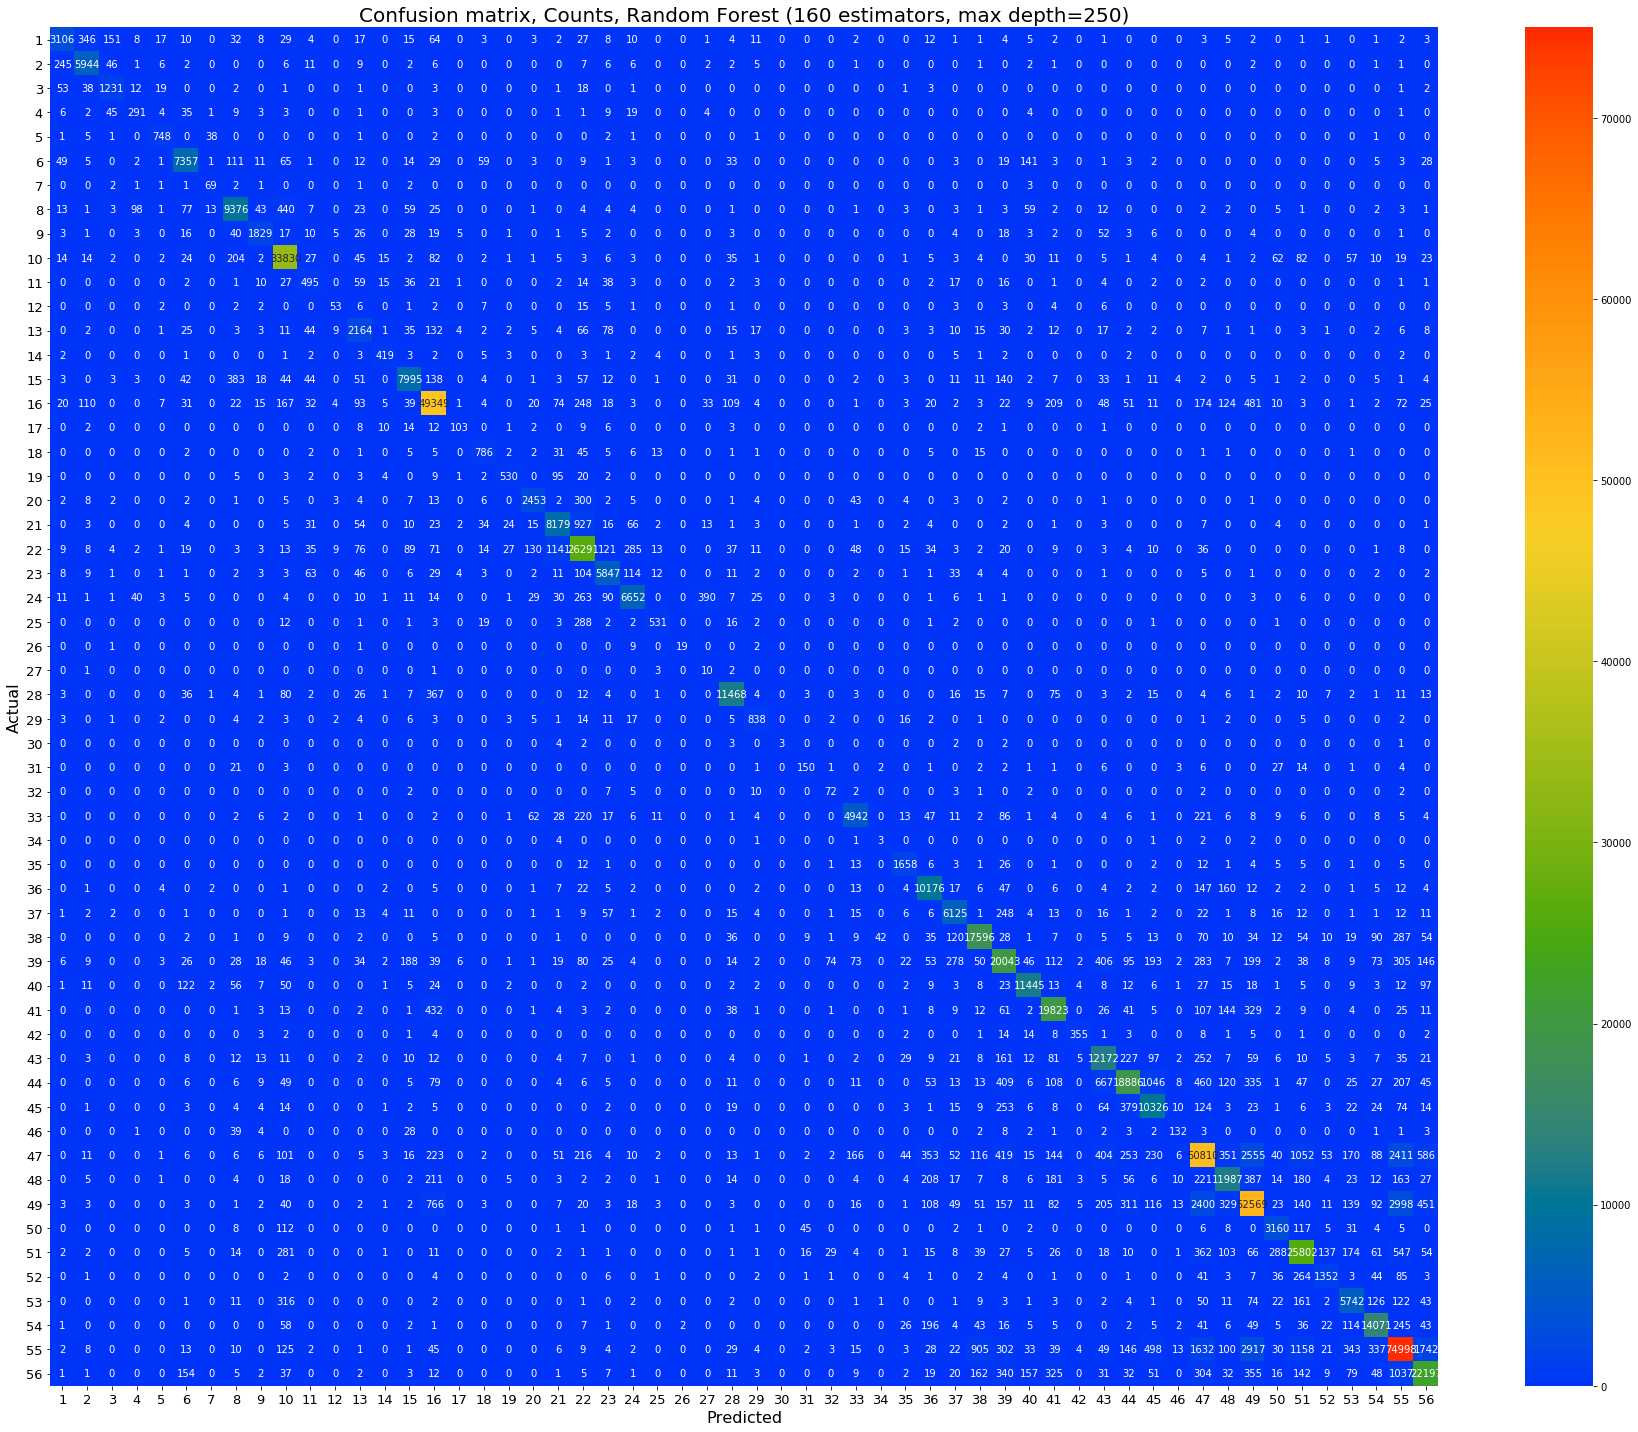

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes,
                       ylabels=FDAcodes, titleText = 'Random Forest (160 estimators, max depth=250)',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix (normalized by row)

* diagonal elements now represent the *recall* for each class

fileNameAugmentString:
 RandomForest160EstimatorsMaxDepth=250
Δt:  5.56s.


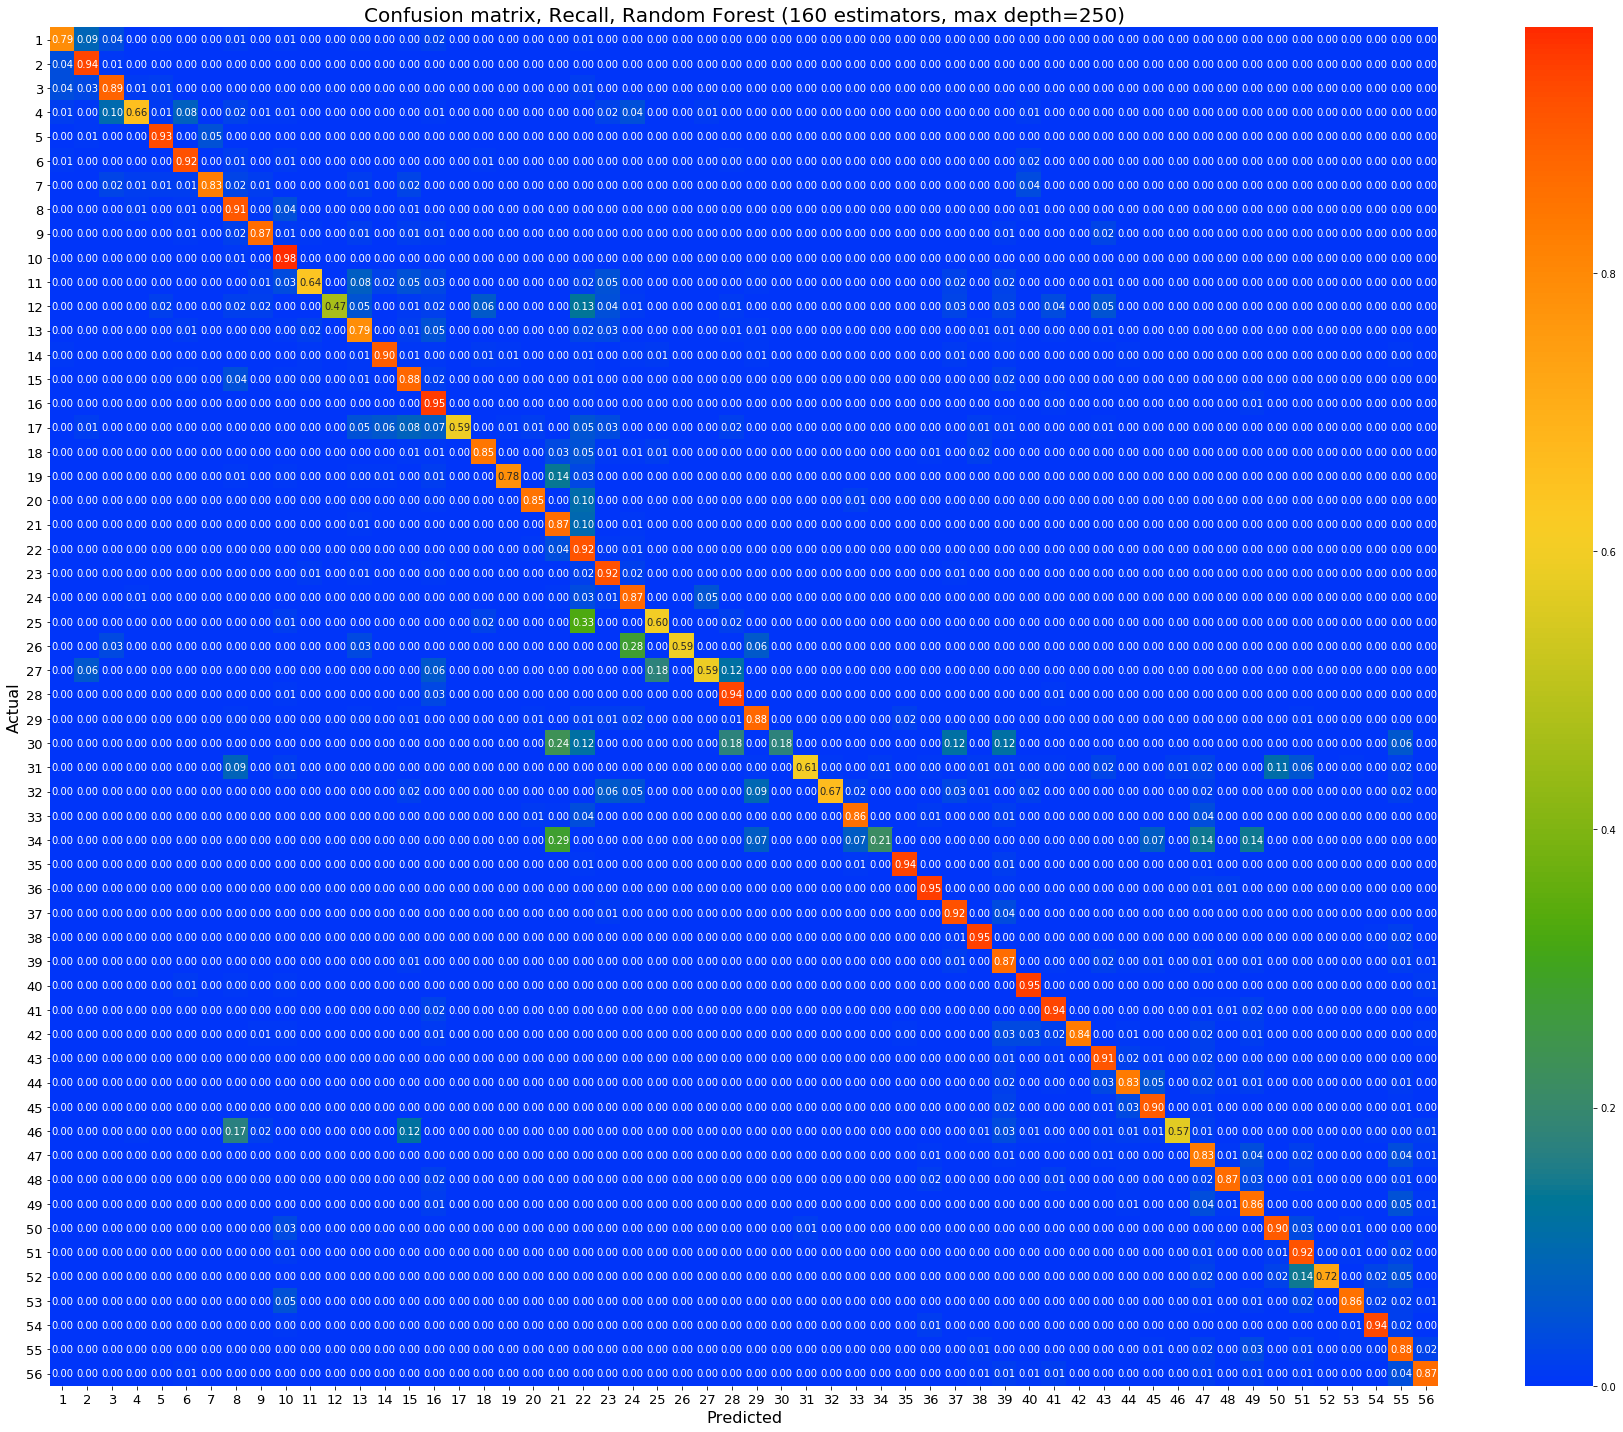

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='recall',
                       ylabels=FDAcodes, titleText = 'Random Forest (160 estimators, max depth=250)',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix (normalized by column)

* diagonal elements now represent the *precision* for each class

fileNameAugmentString:
 RandomForest160EstimatorsMaxDepth=250
Δt:  5.54s.


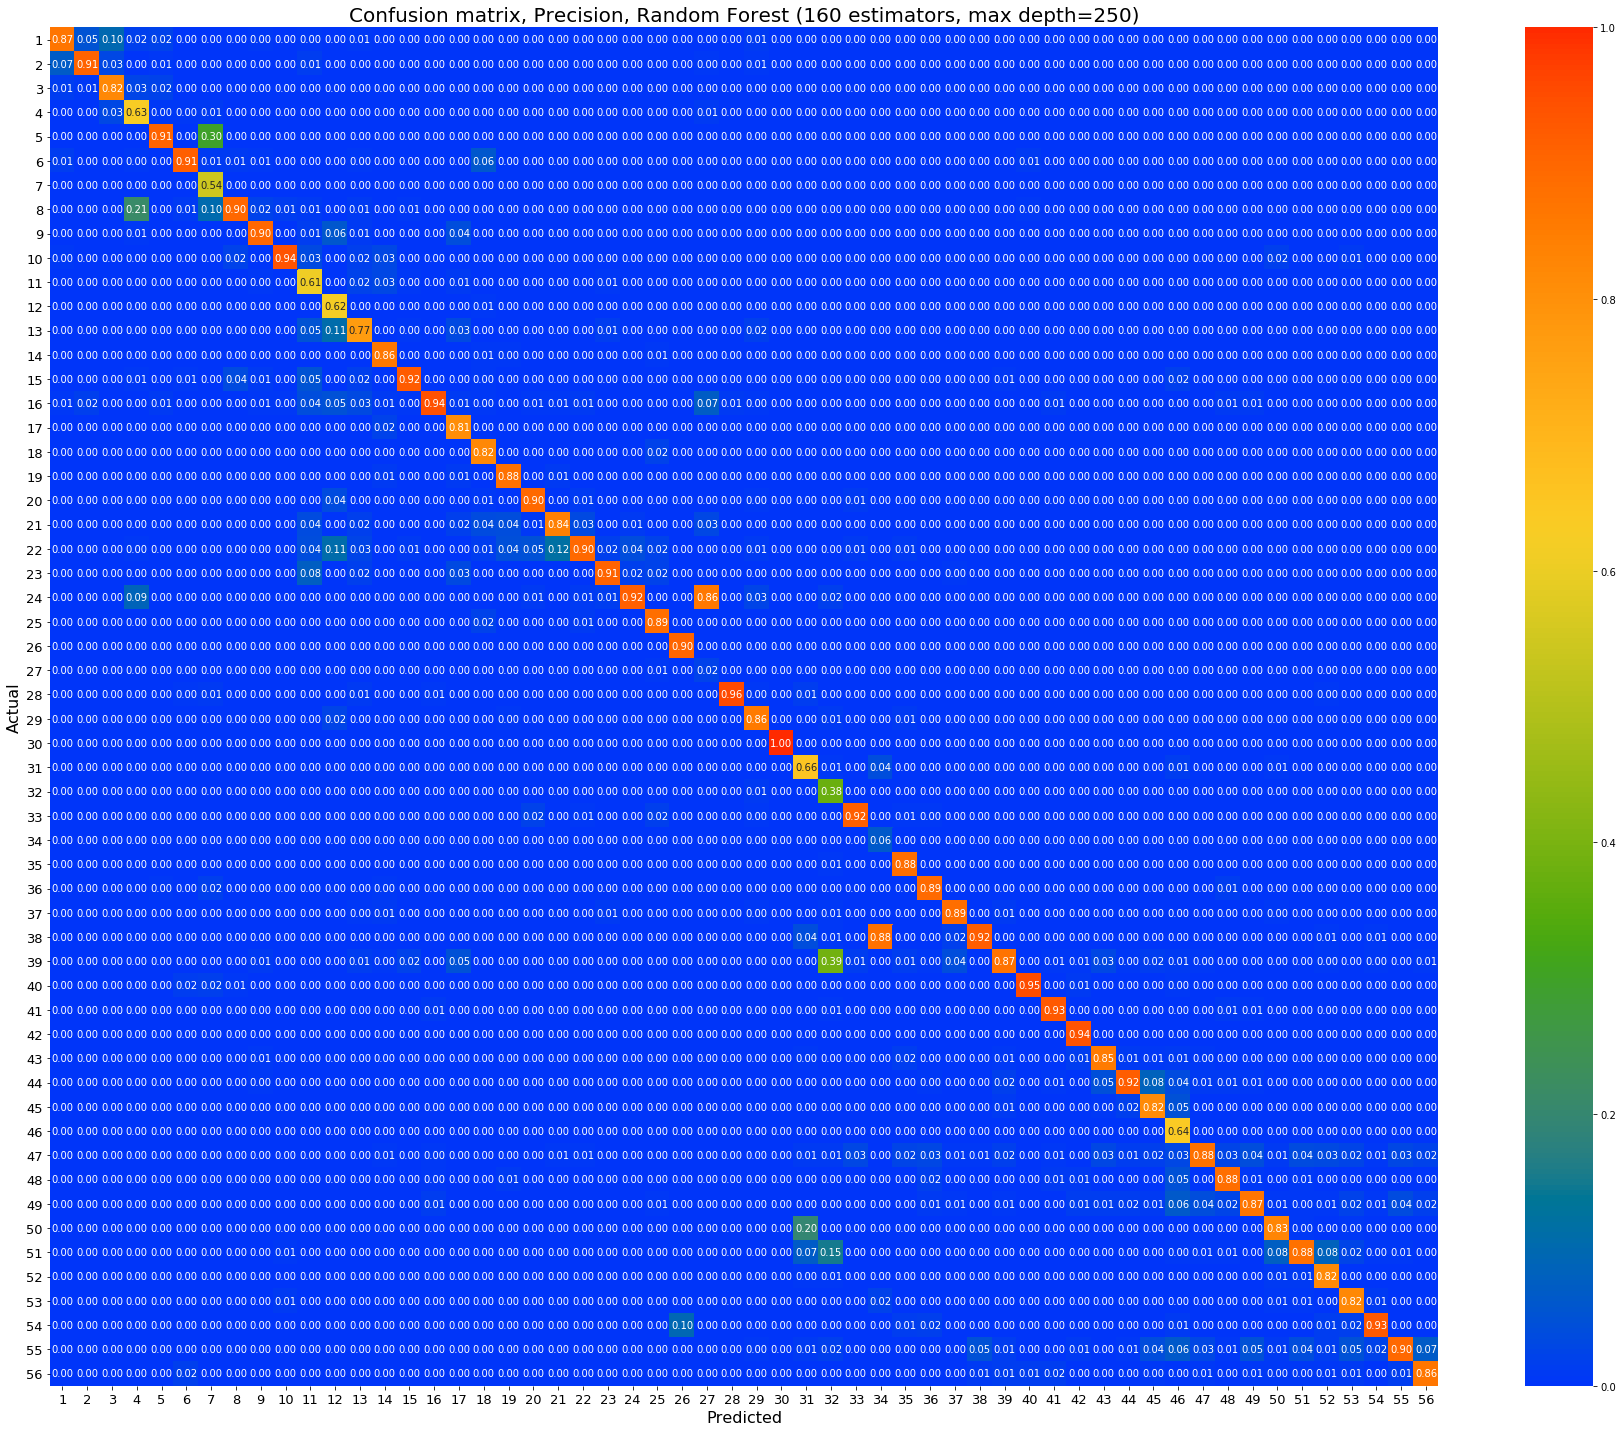

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='precision',
                       ylabels=FDAcodes, titleText = 'Random Forest (160 estimators, max depth=250)',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

In [83]:
del RF

#### Do some garbage collection before building RF models

In [84]:
for i in range(2):
    print('\nCollecting {} ...'.format(i))
    n = gc.collect()
    print('Unreachable objects:', n)
    print('Remaining Garbage:', end=' ')
    pprint.pprint(gc.garbage)


Unreachable objects: 0
Remaining Garbage: []

Unreachable objects: 0
Remaining Garbage: []


### LinearSVC

#### TF-IDF with `FDAISCRITICAL`

* `penalty='l1', dual=False, class_weight='balanced', random_state=myRandomState
* For np.shape(Xtr) = (560000, 178558), fit takes ~45 min.

In [85]:
np.shape(Xtrp), np.shape(yTr), np.shape(Xtep), np.shape(yTe)

((653980, 196111), (653980,), (654006, 196111), (654006,))

In [86]:
print(asctime(gmtime()))
LSVCname = 'LinearSVC0.joblib'

if os.path.isfile(LSVCname):
    RF = load(RFname)
    t1 = time()
else:
    LSVC = LinearSVC(random_state=myRandomState, penalty='l1',
                     dual=False, class_weight='balanced')
    t0 = time()
    LSVC.fit(Xtrp, yTr)
    t1 = time()
    Δt01 = t1 - t0
    print("Δt01: {0} m, {1:4.1f} s.".format(int(Δt01//60), Δt01 % 60.0))

yPred = LSVC.predict(Xtep)
t2 = time()
Δt = t2 - t1
print(f"\n\nΔt: {int(Δt//60)}m, {Δt % 60.0:4.1f}s.")

Thu Apr  9 01:43:26 2020


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1',
          random_state=RandomState(MT19937) at 0x7F8D2CF1C888, tol=0.0001,
          verbose=0)

Δt01: 39 m, 12.2 s.


Δt: 0m,  1.9s.


In [87]:
print(yTe[:20].values)
print(yPred[:20])

[50 22 51 22 49 16 28 44 51 16 45 55 55 16 48 21 38 33 38 55]
[50 22 51 22 49 16 28 39 51 16 39 55 55 16 48 21 38 33 38 55]


**Save model to disk**

In [88]:
if not os.path.isfile(LSVCname):
    dump(LSVC, LSVCname)

['LinearSVC0.joblib']

#### Overall accuracy, precision, recall

In [89]:
confusionMat = confusion_matrix(yTe, yPred)
print(confusionMat)

[[ 3096   390   174 ...     0     0     0]
 [  344  5853    53 ...     0     0     0]
 [  108    36  1172 ...     0     0     0]
 ...
 [    0     1     0 ... 13922   240    59]
 [    8    12     3 ...   616 67916  2463]
 [    2     2     1 ...    71  1171 21206]]


In [90]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

accuracy: 0.860, <precision>: 0.770, <recall>: 0.825


##### Recall, precision by class

In [91]:
print(metrics.classification_report(yTe.values, yPred, target_names=[str(c)for c in FDAcodes]))

              precision    recall  f1-score   support

           1       0.81      0.79      0.80      3922
           2       0.90      0.93      0.91      6315
           3       0.78      0.84      0.81      1387
           4       0.65      0.64      0.65       442
           5       0.87      0.93      0.90       801
           6       0.93      0.93      0.93      7974
           7       0.52      0.82      0.64        83
           8       0.89      0.90      0.90     10293
           9       0.85      0.89      0.87      2107
          10       0.97      0.97      0.97     34644
          11       0.60      0.64      0.62       775
          12       0.50      0.47      0.48       113
          13       0.81      0.80      0.80      2748
          14       0.86      0.89      0.88       467
          15       0.89      0.89      0.89      9078
          16       0.96      0.96      0.96     51679
          17       0.68      0.63      0.66       174
          18       0.79    

In [92]:
classCts = dfTe['fda_q_fixed'].value_counts()

recall = np.diag(confusionMat)/np.sum(confusionMat, axis = 1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis = 0)
f1 = 2.0*precision*recall/(precision + recall)
print("class\tprecision\trecall\tf1\tsize")

for FDAcode, classCt in classCts.iteritems():
    print(f"{FDAcode}\t{precision[FDAcode - 1]:0.3f}\t\t{recall[FDAcode - 1]:0.3f}\t{f1[FDAcode - 1]:0.3f}\t\t{classCt:d}")

class	precision	recall	f1	size
55	0.876		0.793	0.833		85601
49	0.798		0.791	0.794		61157
47	0.839		0.734	0.783		60999
16	0.964		0.956	0.960		51679
10	0.969		0.970	0.969		34644
22	0.916		0.868	0.891		28605
51	0.839		0.879	0.858		28115
56	0.801		0.828	0.815		25612
39	0.816		0.837	0.826		23073
44	0.843		0.798	0.820		22667
41	0.897		0.950	0.923		21121
38	0.893		0.942	0.917		18567
54	0.903		0.928	0.915		15008
48	0.777		0.857	0.815		13801
43	0.797		0.889	0.840		13319
28	0.933		0.953	0.943		12213
40	0.948		0.961	0.955		12008
45	0.761		0.870	0.812		11423
36	0.869		0.943	0.905		10676
8	0.890		0.903	0.896		10293
21	0.782		0.841	0.810		9437
15	0.888		0.893	0.890		9078
6	0.931		0.931	0.931		7974
24	0.876		0.919	0.897		7609
53	0.705		0.889	0.787		6714
37	0.878		0.924	0.900		6647
23	0.892		0.924	0.907		6338
2	0.899		0.927	0.913		6315
33	0.754		0.921	0.829		5747
1	0.805		0.789	0.797		3922
50	0.770		0.925	0.840		3510
20	0.806		0.902	0.851		2874
13	0.808		0.799	0.803		2748
9	0.850		0.888	0.868		2107
52

##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

In [93]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

fileNameAugmentString:
 LinearSvcL1PenaltyDual=false
Δt:  5.17s.


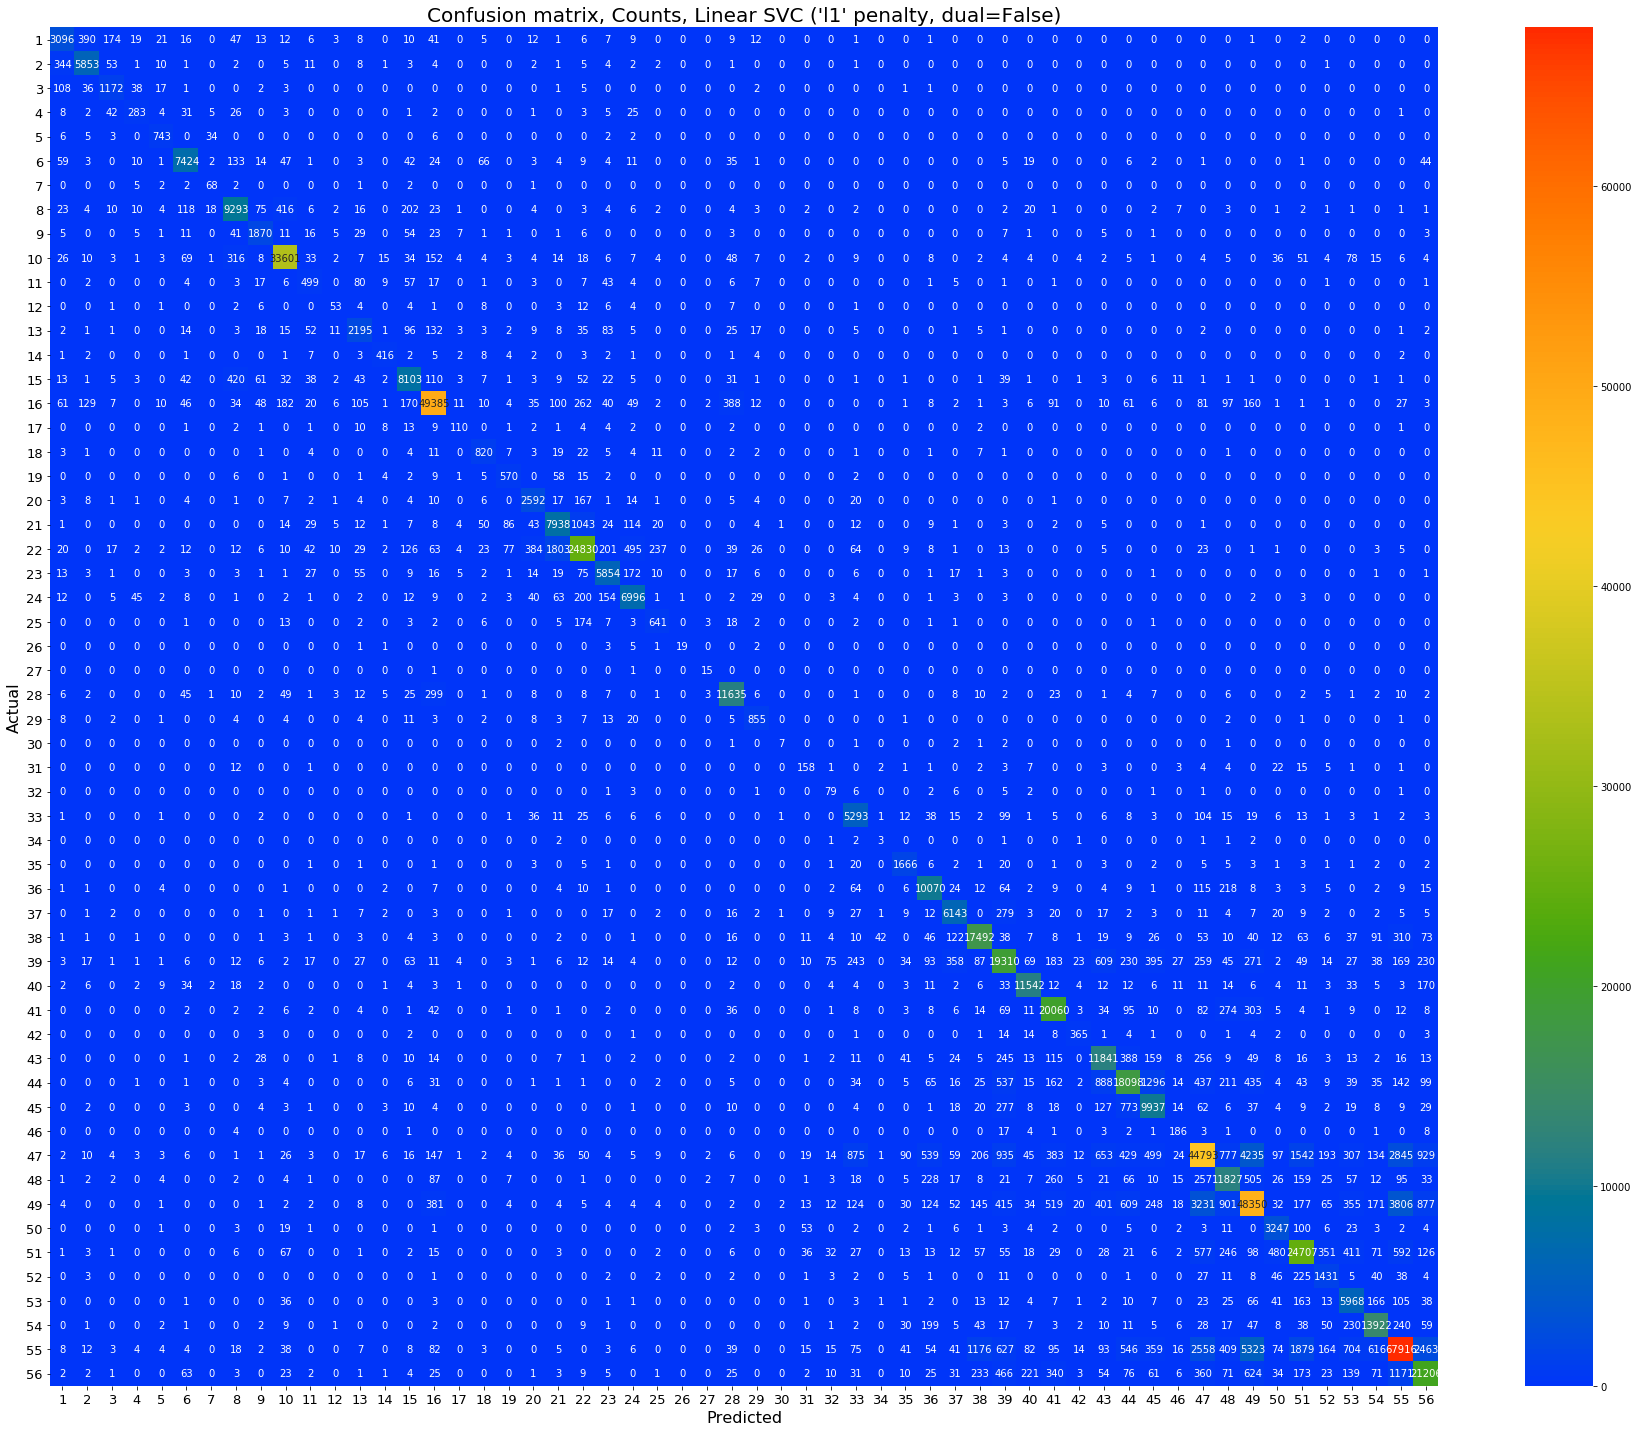

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes,
                       ylabels=FDAcodes, titleText = "Linear SVC ('l1' penalty, dual=False)",
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix (normalized by row)

* diagonal elements now represent the *recall* for each class

fileNameAugmentString:
 LinearSvcL1PenaltyDual=false
Δt:  5.71s.


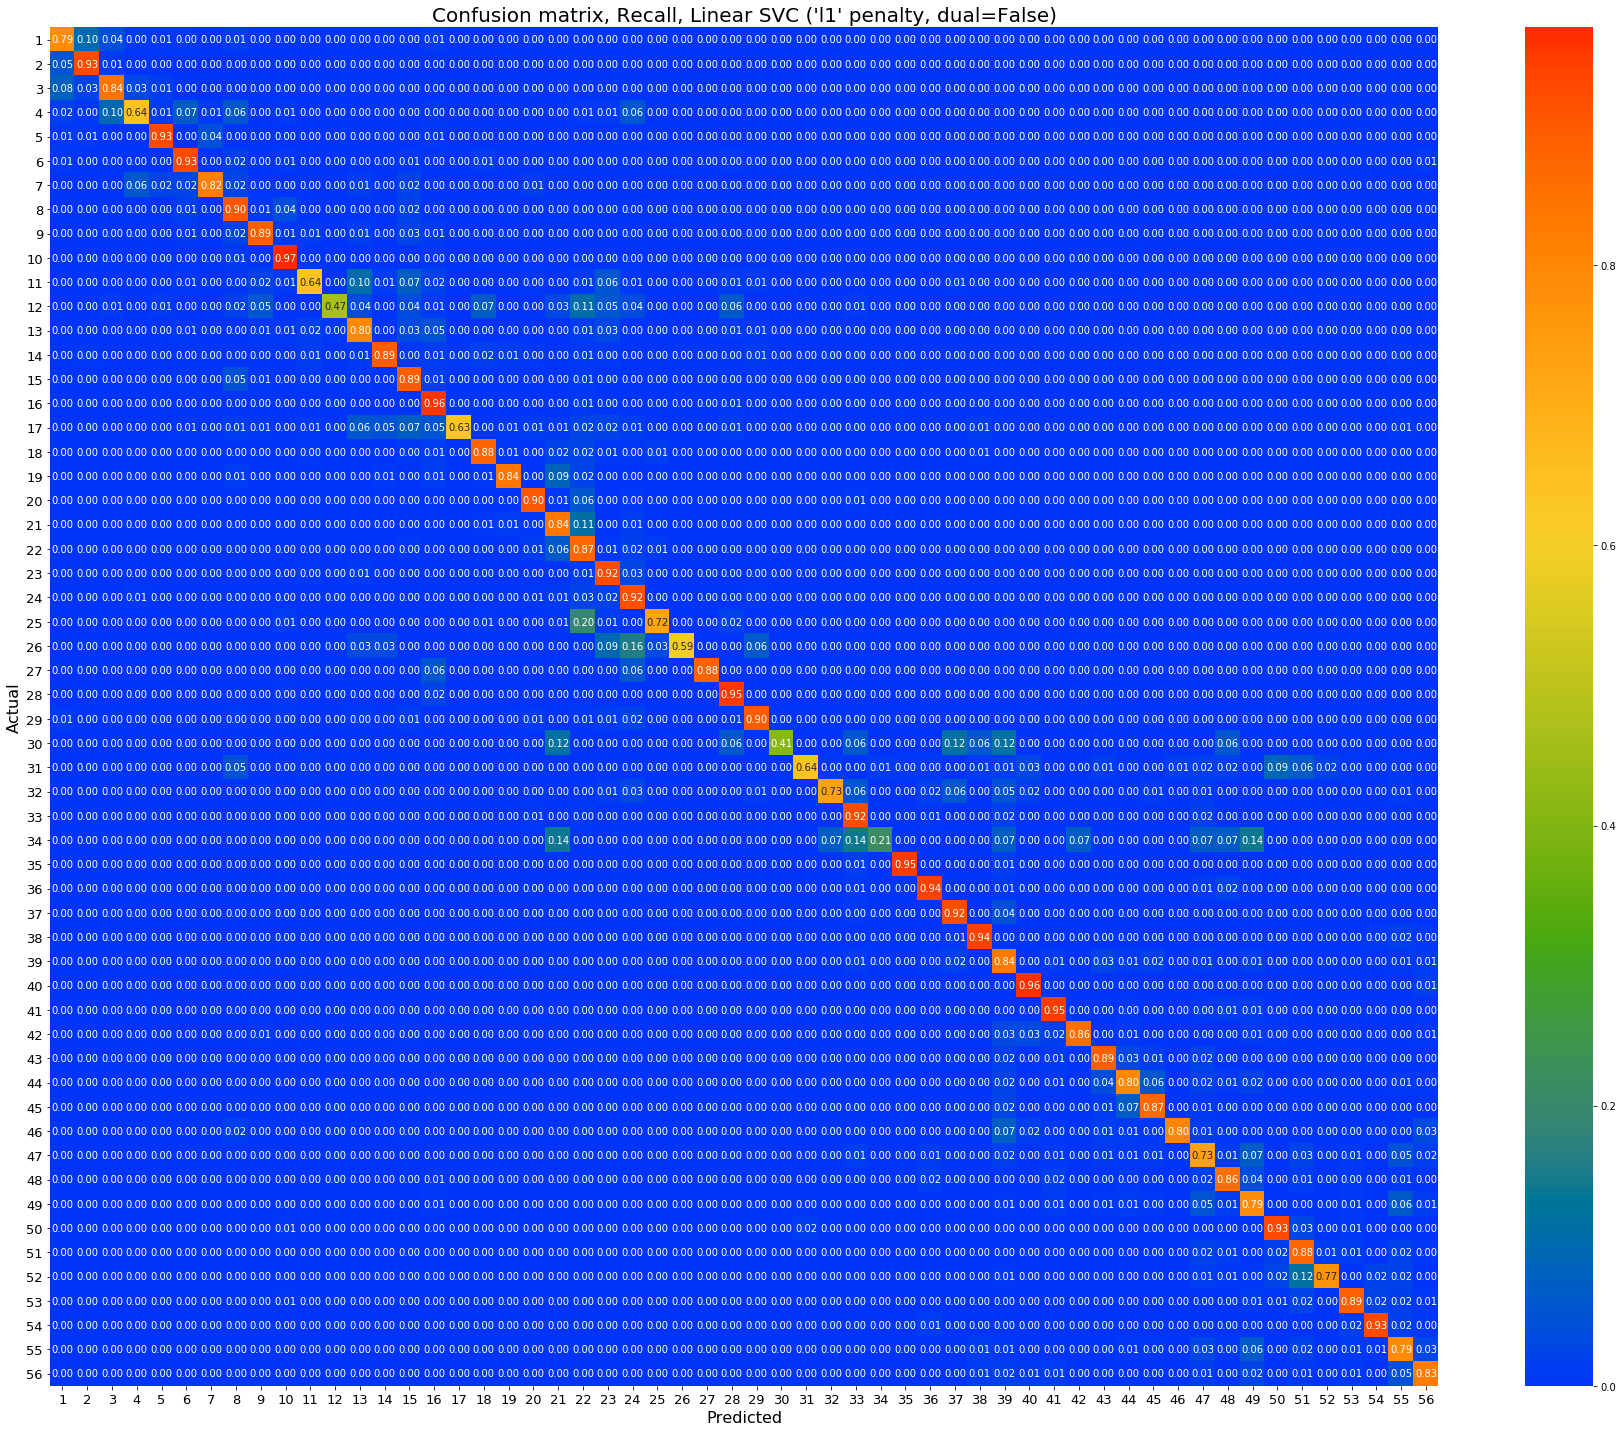

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='recall',
                       ylabels=FDAcodes, titleText = "Linear SVC ('l1' penalty, dual=False)",
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix (normalized by column)

* diagonal elements now represent the *precision* for each class

fileNameAugmentString:
 LinearSvcL1PenaltyDual=false
Δt:  5.66s.


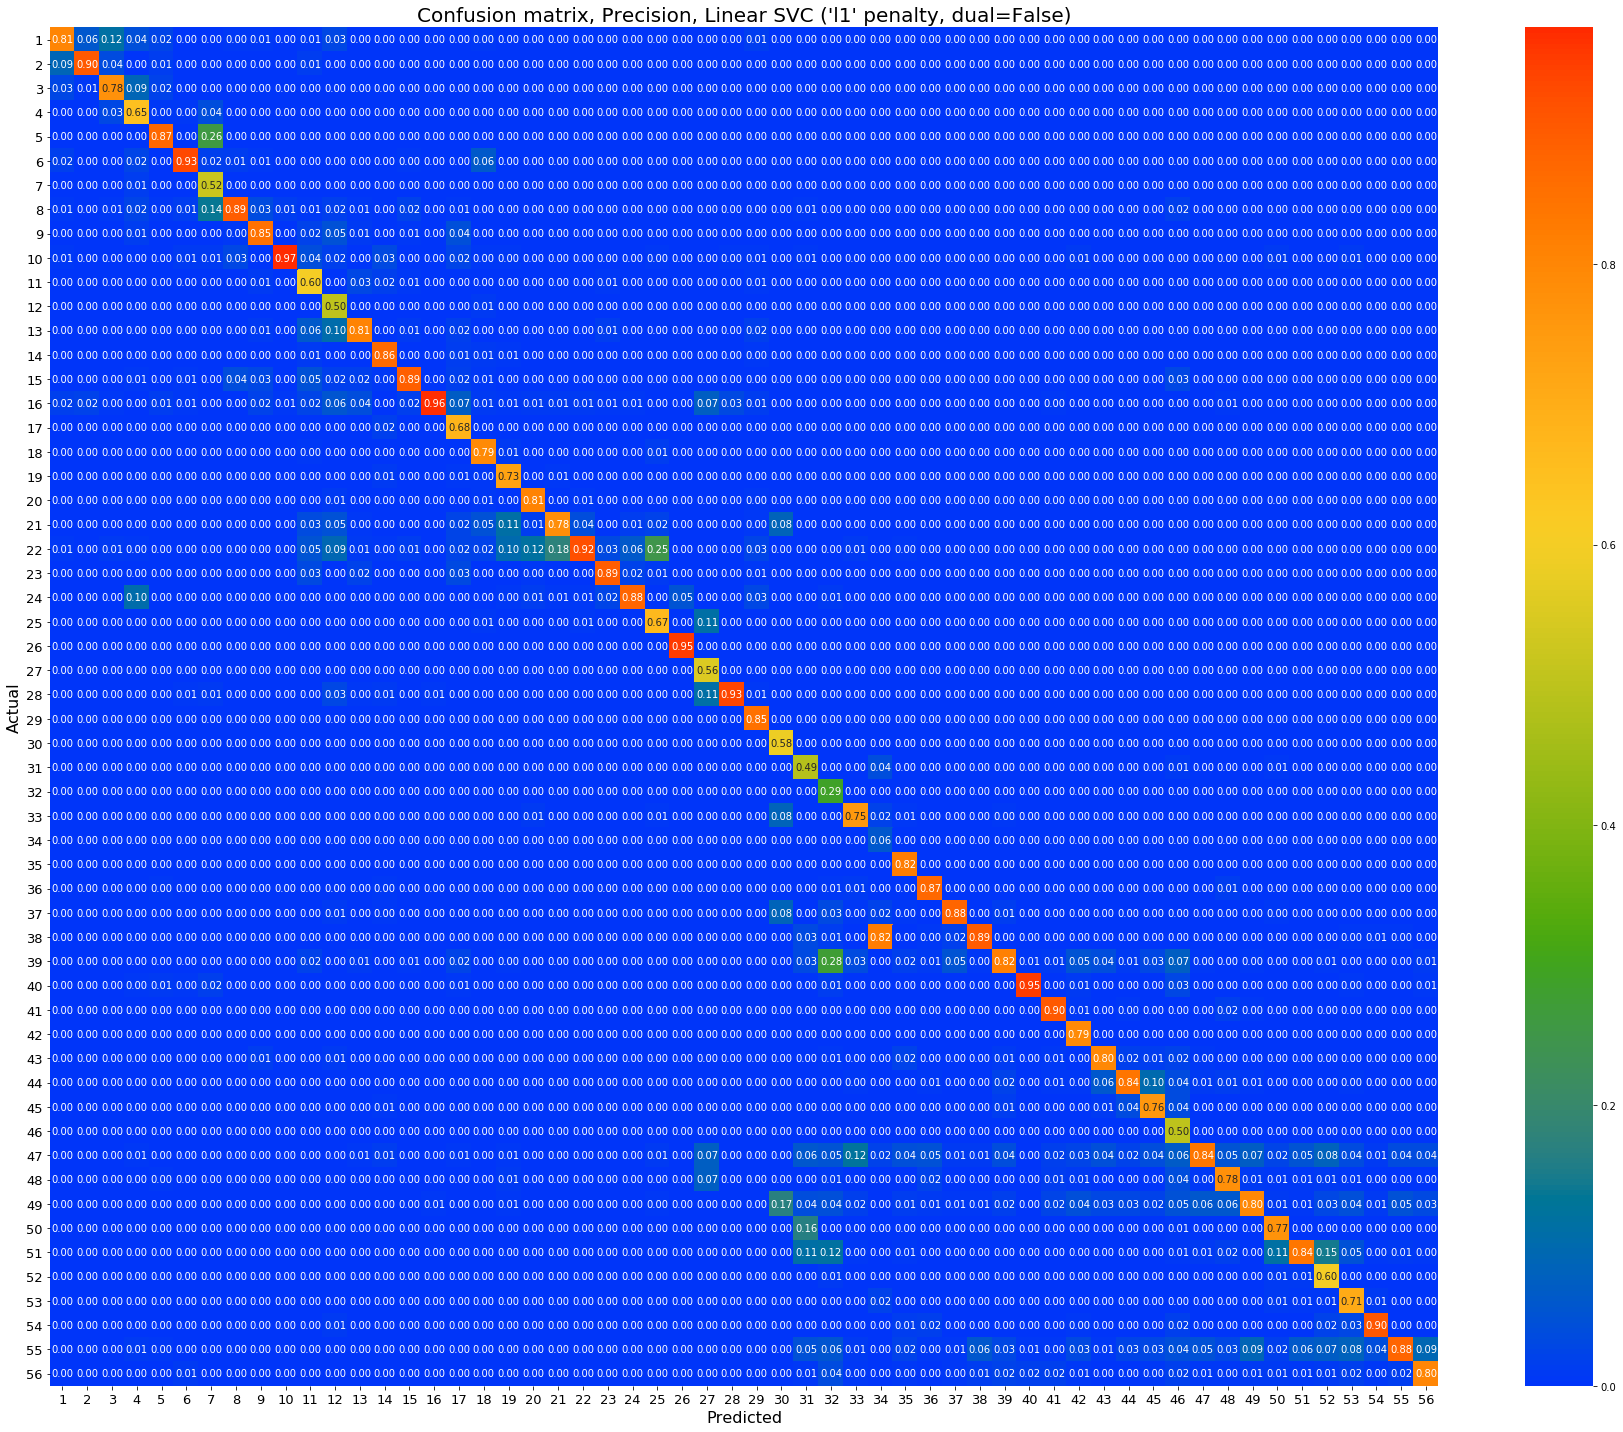

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='precision',
                       ylabels=FDAcodes, titleText = "Linear SVC ('l1' penalty, dual=False)",
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

In [97]:
del LSVC

#### Do some garbage collection before building RF models

In [98]:
for i in range(2):
    print('\nCollecting {} ...'.format(i))
    n = gc.collect()
    print('Unreachable objects:', n)
    print('Remaining Garbage:', end=' ')
    pprint.pprint(gc.garbage)


Unreachable objects: 0
Remaining Garbage: []

Unreachable objects: 0
Remaining Garbage: []


### Complement Naive Bayes

#### TF-IDF with `FDAISCRITICAL`

* default hyperparameters, except `fit_prior=False`, as we have enforced train clasess with ≥ 14 elements
* For np.shape(Xtr) = (560000, 178558), fit takes ~ min.

In [99]:
np.shape(Xtrp), np.shape(yTr), np.shape(Xtep), np.shape(yTe)

((653980, 196111), (653980,), (654006, 196111), (654006,))

In [100]:
print(asctime(gmtime()))
CNBname = 'ComplementNaiveBayes0.joblib'

if os.path.isfile(CNBname):
    CNB = load(CNBname)
    t1 = time()
else:
    CNB = ComplementNB(fit_prior=False)
    t0 = time()
    CNB.fit(Xtrp, yTr)
    t1 = time()
    Δt01 = t1 - t0
    print("Δt01: {0} m, {1:4.1f} s.".format(int(Δt01//60), Δt01 % 60.0))

yPred = CNB.predict(Xtep)
t2 = time()
Δt = t2 - t1
print(f"\n\nΔt: {int(Δt//60)}m, {Δt % 60.0:4.1f}s.")

Thu Apr  9 02:23:14 2020


ComplementNB(alpha=1.0, class_prior=None, fit_prior=False, norm=False)

Δt01: 0 m,  2.6 s.


Δt: 0m,  1.8s.


In [101]:
print(yTe[:20].values)
print(yPred[:20])

[50 22 51 22 49 16 28 44 51 16 45 55 55 16 48 21 38 33 38 55]
[10 22 51 22 16 16 28 39 51 16 39 55 55 16 48 21 38 33 38 55]


**Save model to disk**

In [102]:
if not os.path.isfile(CNBname):
    dump(CNB, CNBname)

['ComplementNaiveBayes0.joblib']

#### Overall accuracy, precision, recall

In [103]:
confusionMat = confusion_matrix(yTe, yPred)
print(confusionMat)

[[ 2280   656   295 ...     1    22     5]
 [  235  5939    39 ...     0     3     2]
 [   80    70  1152 ...     0     0     0]
 ...
 [    5     1     0 ... 13512   403    50]
 [   10    30     1 ...   496 71125  1786]
 [    5    14     0 ...    83  2040 19767]]


In [104]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

accuracy: 0.794, <precision>: nan, <recall>: 0.603


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


##### Recall, precision by class

In [105]:
print(metrics.classification_report(yTe.values, yPred, target_names=[str(c)for c in FDAcodes]))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.84      0.58      0.69      3922
           2       0.84      0.94      0.89      6315
           3       0.68      0.83      0.75      1387
           4       0.76      0.12      0.20       442
           5       0.85      0.96      0.90       801
           6       0.79      0.87      0.82      7974
           7       0.33      0.01      0.02        83
           8       0.76      0.88      0.82     10293
           9       0.85      0.71      0.77      2107
          10       0.80      0.95      0.87     34644
          11       0.73      0.23      0.35       775
          12       1.00      0.07      0.13       113
          13       0.80      0.63      0.71      2748
          14       0.81      0.80      0.81       467
          15       0.77      0.72      0.75      9078
          16       0.76      0.77      0.77     51679
          17       0.66      0.16      0.25       174
          18       0.85    

In [106]:
classCts = dfTe['fda_q_fixed'].value_counts()

recall = np.diag(confusionMat)/np.sum(confusionMat, axis = 1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis = 0)
f1 = 2.0*precision*recall/(precision + recall)
print("class\tprecision\trecall\tf1\tsize")

for FDAcode, classCt in classCts.iteritems():
    print(f"{FDAcode}\t{precision[FDAcode - 1]:0.3f}\t\t{recall[FDAcode - 1]:0.3f}\t{f1[FDAcode - 1]:0.3f}\t\t{classCt:d}")

class	precision	recall	f1	size
55	0.813		0.831	0.822		85601
49	0.712		0.720	0.716		61157
47	0.809		0.705	0.753		60999
16	0.765		0.773	0.769		51679
10	0.796		0.951	0.867		34644
22	0.685		0.931	0.789		28605
51	0.802		0.850	0.825		28115
56	0.809		0.772	0.790		25612
39	0.804		0.719	0.759		23073
44	0.833		0.747	0.788		22667
41	0.809		0.895	0.850		21121
38	0.889		0.923	0.906		18567
54	0.886		0.900	0.893		15008
48	0.836		0.662	0.739		13801
43	0.755		0.853	0.801		13319
28	0.893		0.823	0.856		12213
40	0.897		0.895	0.896		12008
45	0.738		0.801	0.768		11423
36	0.855		0.924	0.888		10676
8	0.757		0.884	0.816		10293
21	0.767		0.601	0.674		9437
15	0.774		0.721	0.747		9078
6	0.788		0.865	0.825		7974
24	0.834		0.872	0.852		7609
53	0.823		0.579	0.679		6714
37	0.843		0.846	0.845		6647
23	0.832		0.867	0.849		6338
2	0.836		0.940	0.885		6315
33	0.780		0.591	0.673		5747
1	0.837		0.581	0.686		3922
50	0.824		0.479	0.606		3510
20	0.821		0.333	0.474		2874
13	0.802		0.635	0.709		2748
9	0.846		0.715	0.775		2107
52

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

In [107]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

fileNameAugmentString:
 ComplementNaiveBayes
Δt:  5.20s.


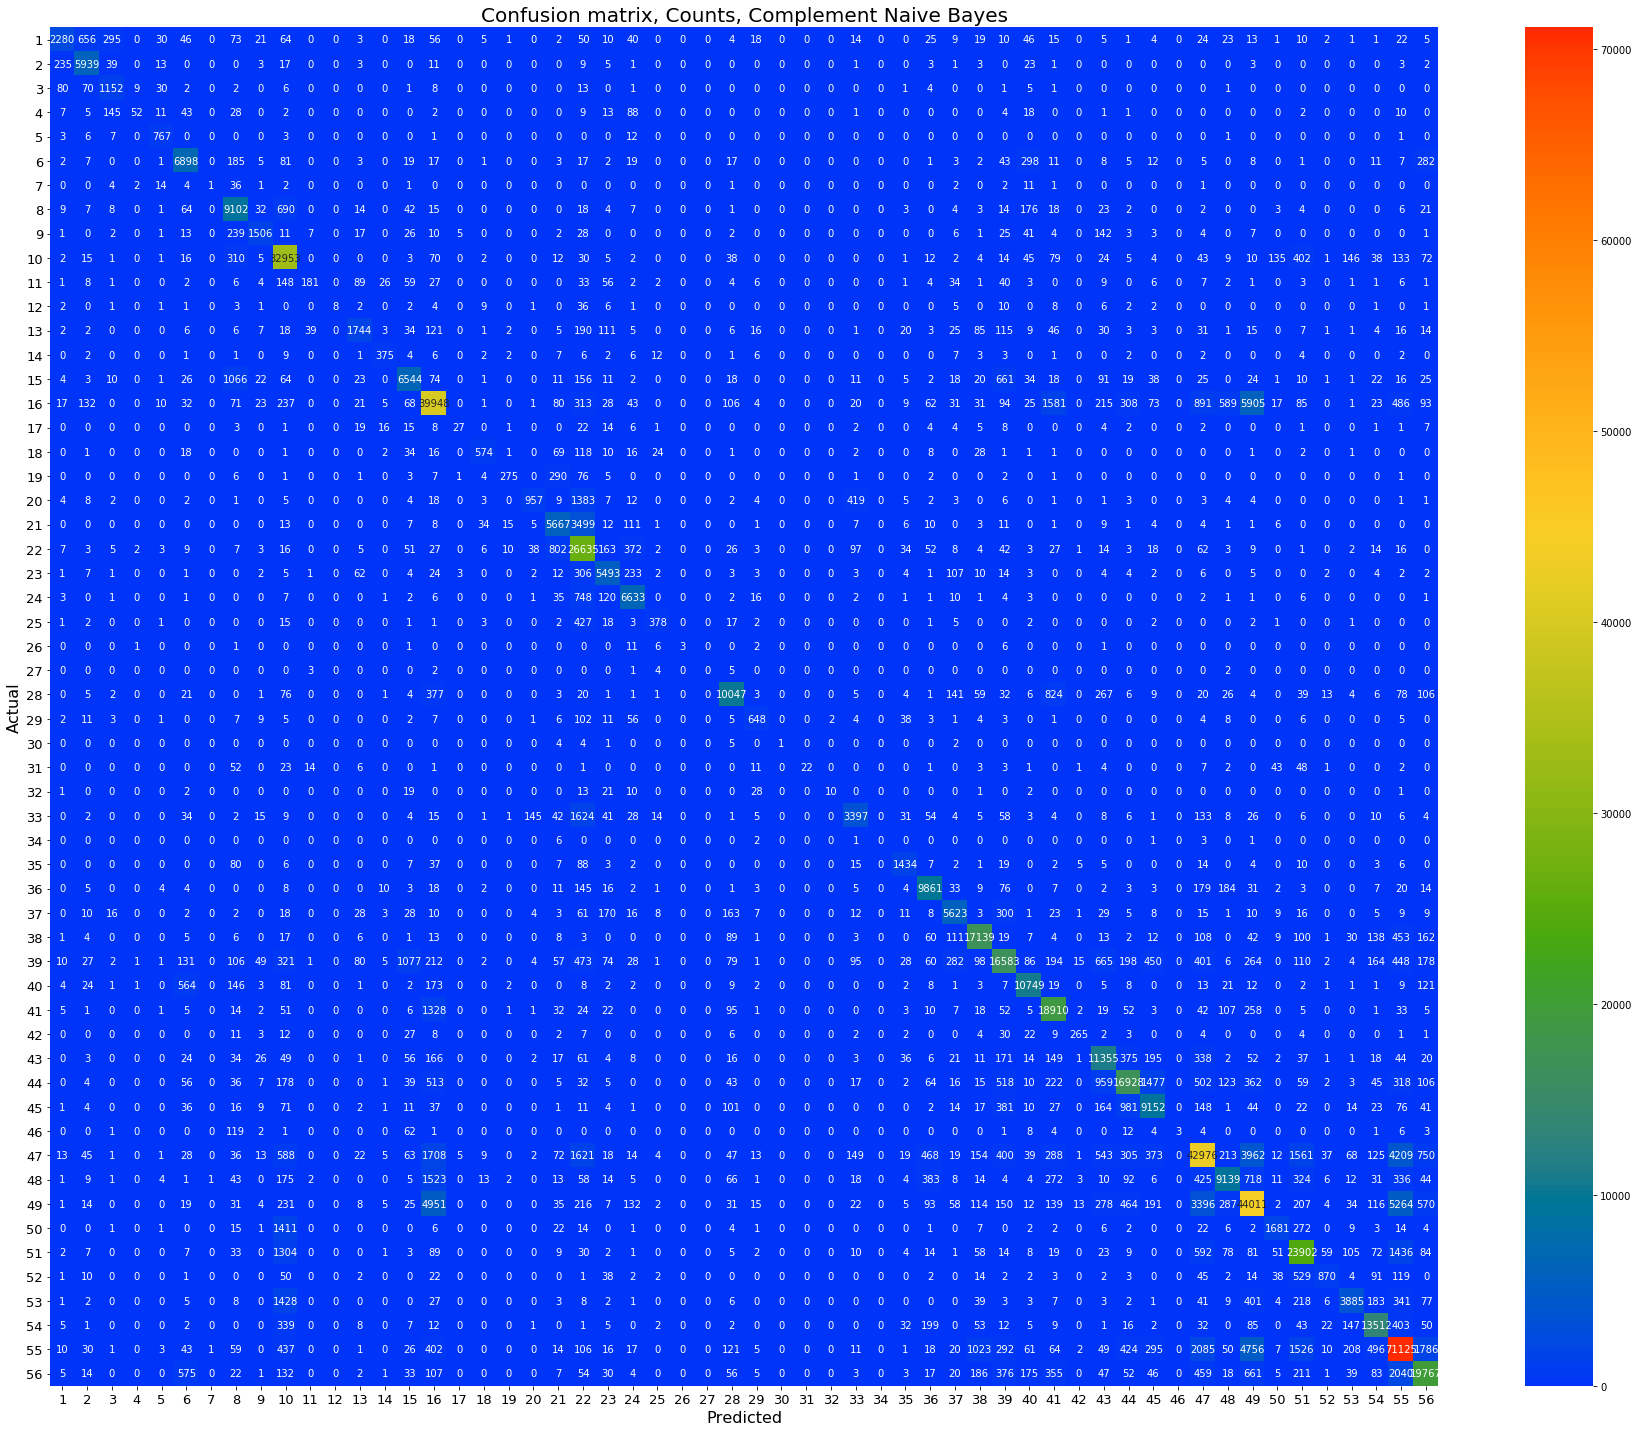

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes,
                       ylabels=FDAcodes, titleText = 'Complement Naive Bayes',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix (normalized by row)

* diagonal elements now represent the *recall* for each class

fileNameAugmentString:
 ComplementNaiveBayes
Δt:  5.59s.


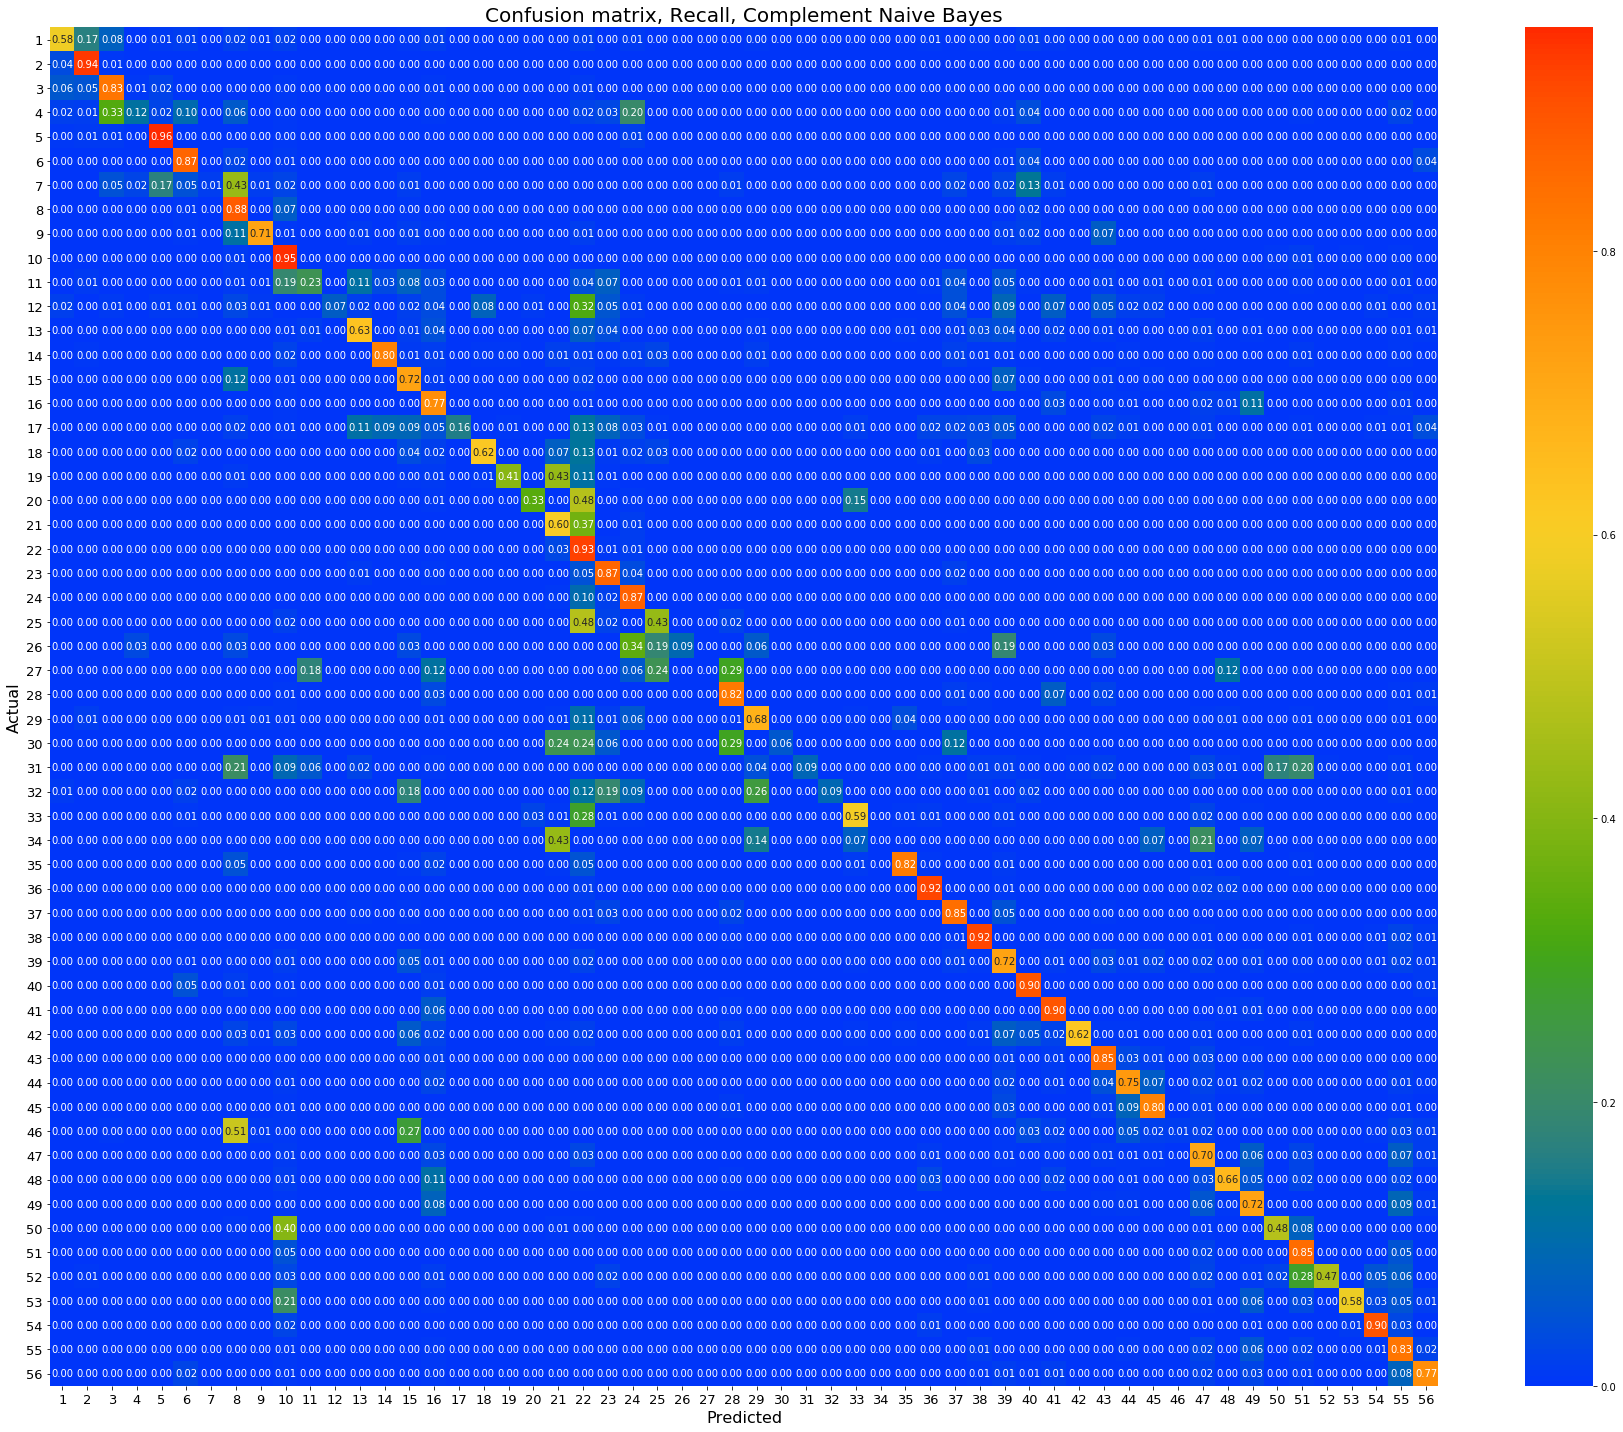

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='recall',
                       ylabels=FDAcodes, titleText = 'Complement Naive Bayes',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix (normalized by column)

* diagonal elements now represent the *precision* for each class

/home/wilber/work/Mlib/plotHelpers/plotHelpers.py:96: RuntimeWarning: invalid value encountered in true_divide
  confusionMat.sum(axis=0)[np.newaxis, :])


fileNameAugmentString:
 ComplementNaiveBayes
Δt:  5.44s.


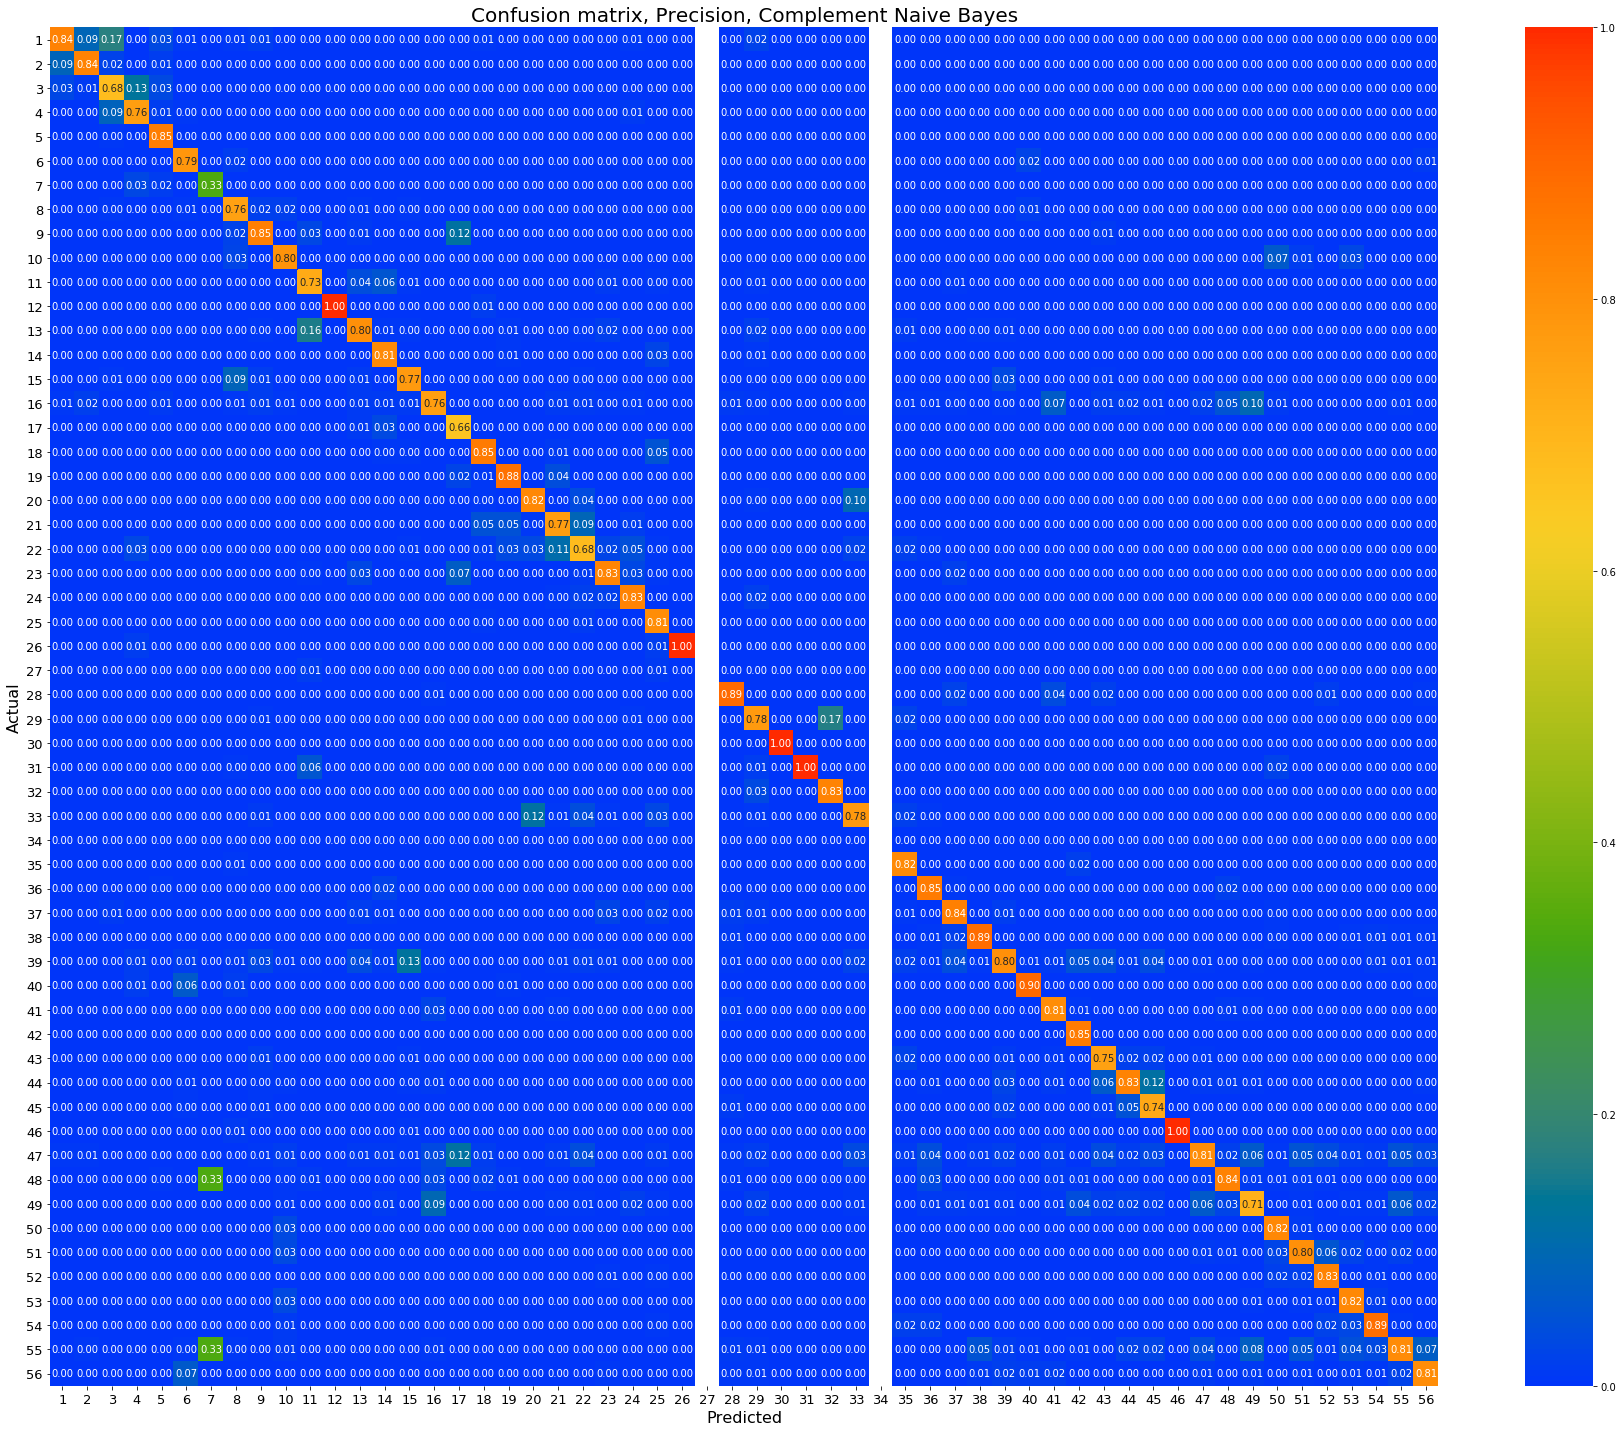

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='precision',
                       ylabels=FDAcodes, titleText = 'Complement Naive Bayes',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)